# Learning a quadratic prior

This code attempts to learn a concave quadratic prior $J(x) = -\frac{1}{4}||x||_2^2$ in the context of a Hamilton-Jacobi PDE with a quadratic Hamiltonian $H(p) = \frac{1}{2}||p||_2^2$.
The LPN learns the function $\psi(x) = ||x||_2^2$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/concave_quadratic_prior_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

## Parameters

# === Section ===

In [2]:
# Parameters

dim_exp = 32  
data_points_exp = 40000 
iterations_exp_initial = 1 
iterations_exp_long = 500000 
a_exp = 4 # Grid limit for sampling y_j if using uniform, e.g., y_j in [-a, a]^d
spacing = 100 # For plotting cross-sections


# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 5       # beta of softplus
hidden = 256     # number of hidden units
layers = 2      # number of layers
eps = 0.5
# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch 

# === Helper Functions ===

def inner_prod(x, y):
    return np.sum(x * y, axis=1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def cvx_true_concave_quad(y_points): # y_points is N x dim
    """
    Computes the target function psi(y) = ||y||_2^2 for the given problem.
    """
    return euclid_norm_sq(y_points)

def prior_true_concave_quad(x_points):
    """
    Computes the true concave prior J(x) = -1/4 * ||x||_2^2.
    """
    return -0.25 * euclid_norm_sq(x_points)

def invert_prior_lpn(x, model, INVERT_MODE):
    y = invert(x,model,INVERT_MODE)
    return y

def evaluate_learned_prior_lpn(x_eval_points, y_inverted_points, model):
    try:
        y_tensor = torch.from_numpy(y_inverted_points).float().to(device)
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().cpu().numpy()
    except NameError: 
        print("Warning: 'device' not defined. Assuming CPU for evaluate_learned_prior.")
        y_tensor = torch.from_numpy(y_inverted_points).float()
        psi_of_y_inverted = model.scalar(y_tensor).squeeze(1).detach().numpy()
    prior_est = inner_prod(x_eval_points, y_inverted_points) - 0.5 * euclid_norm_sq(x_eval_points) - psi_of_y_inverted
    return prior_est


def compute_square_cross_sections(a, spacing, dim):
    xi = np.linspace(-a, a, spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid)
    x1_0_points[:, 0] = xi
    x2_0_points = np.copy(grid)
    if dim > 1:
        x2_0_points[:, 1] = xi
    elif dim == 1:
        x2_0_points = x1_0_points.copy()
    return xi, x1_0_points, x2_0_points

def cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim):
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    x1_0_psi_true = cvx_true_concave_quad(x1_0_points)
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_psi_true = cvx_true_concave_quad(x2_0_points)
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else: 
        x2_0_psi_true = x1_0_psi_true 
        x2_0_J_true = x1_0_J_true
        
    x1_0_psi_est = cvx(x1_0_points, model) 
    y1_inverted = invert_prior_lpn(x1_0_points, model, INVERT_MODE)
    x1_0_J_est = evaluate_learned_prior_lpn(x1_0_points,y1_inverted, model)
    if dim > 1:
        x2_0_psi_est = cvx(x2_0_points, model)
        y2_inverted = invert_prior_lpn(x2_0_points, model, INVERT_MODE)
        x2_0_J_est = evaluate_learned_prior_lpn(x2_0_points,y2_inverted, model)
    else:
        x2_0_psi_est = x1_0_psi_est
        x2_0_J_est = x1_0_J_est
        
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
    plt.plot(xi, x1_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=\\|x\\|_1$")
    plt.grid(True)
    plt.title(f"$\\psi(y_1,0,...)$ - Dim {dim}, $J(x)=\\|x\\|_1$")
    plt.xlabel('$y_1$')
    plt.ylabel('$\\psi(y_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2) # Second plot for psi if dim > 1
        plt.plot(xi, x2_0_psi_est, "-", ms=5, label="LPN (Learned $\\psi$)")
        plt.plot(xi, x2_0_psi_true, "--", ms=5, label="True $\\psi$ for $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"$\\psi(0,y_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$y_2$')
        plt.ylabel('$\\psi(0,y_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_est, "-", label="LPN (Learned $J$)")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_est, "-", label="LPN (Learned $J$)")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4\\|x\\|_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ - Dim {dim}, $J(x)=-1/4\\|x\\|_2^2$")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    plt.show()

def plot_all_concave_quad(model, a, spacing, INVERT_MODE, dim):
    print(f"\n--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim={dim}) ---")
    cross_sections_plots_concave_quad(model, a, spacing, INVERT_MODE, dim)



In [4]:
def evaluate_learned_H(model, a, spacing, dim):
    """
    Calculates and plots the approximate Hamiltonian H_theta.
    H_theta(p) = max_k { <p, eta_k> - b_k }
    where eta_k = x_k - grad_psi(x_k) and b_k = 0.5 * ||eta_k||^2
    """
    x_k_np = np.random.uniform(-a, a, (data_points_exp, dim))
    x_k_tensor = torch.from_numpy(x_k_np).float().to(device)
    x_k_tensor.requires_grad_(True)
    grad_psi_k_tensor = model(x_k_tensor)

    eta_k_tensor = x_k_tensor - grad_psi_k_tensor
    b_k_tensor = 0.5 * torch.sum(eta_k_tensor**2, dim=1, keepdim=True)

    xi = np.linspace(-a, a, spacing)
    p_eval_points_np = np.zeros((xi.size, dim))
    p_eval_points_np[:, 0] = xi
    p_eval_tensor = torch.from_numpy(p_eval_points_np).float().to(device)

    # Compute H_theta(p) for the cross-section
    inner_prods = torch.matmul(p_eval_tensor, eta_k_tensor.T)  # (spacing x data_points)
    H_theta_p_tensor = torch.max(inner_prods - b_k_tensor.T, dim=1, keepdim=True)[0]
    H_theta_p_np = H_theta_p_tensor.detach().cpu().numpy().flatten()

    # Compute true Hamiltonian H(p) = 0.5 * ||p||^2
    H_true_p_np = 0.5 * euclid_norm_sq(p_eval_points_np)

    plt.figure(figsize=(6,5))
    plt.plot(xi, H_theta_p_np, "-", label="Learned Hamiltonian $H_{\\theta}(p_1,0,...)$")
    plt.plot(xi, H_true_p_np, "--", label="True Hamiltonian $H(p)=1/2||p||_2^2$")
    plt.grid(True)
    plt.title(f"Hamiltonian Comparison - Dim {dim}")
    plt.xlabel('$p_1$')
    plt.ylabel('H(p)')
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Generate Training Data

In [5]:
# --- Generate Training Data for the new experiment ---
print("--- Generating Training Data for Concave Quadratic Prior ---")
y_j_exp_np = np.random.uniform(-a_exp, a_exp, (data_points_exp, dim_exp))
psi_samples_exp_np = cvx_true_concave_quad(y_j_exp_np)
psi_samples_exp_np = psi_samples_exp_np.reshape(-1, 1)

y_j_exp_tensor = torch.from_numpy(y_j_exp_np).float().to(device)
psi_samples_exp_tensor = torch.from_numpy(psi_samples_exp_np).float().to(device)
print(f"Generated training data: y_j_exp_tensor shape {y_j_exp_tensor.shape}, psi_samples_exp_tensor shape {psi_samples_exp_tensor.shape}")

# --- ADD THIS TO MOVE DATA TO GPU ---
y_j_exp_tensor = y_j_exp_tensor.to(device)
psi_samples_exp_tensor = psi_samples_exp_tensor.to(device)

--- Generating Training Data for Concave Quadratic Prior ---


Generated training data: y_j_exp_tensor shape torch.Size([40000, 32]), psi_samples_exp_tensor shape torch.Size([40000, 1])


## Training function

In [6]:
def single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    #elif loss_type == 0:
    #    loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [7]:

# --- Train and Plot ---
print("\n--- Training LPN for Concave Quadratic Prior (Quadratic H) ---")
lpn_model_concave_quad_l2 = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta,eps=1e-3).to(device)
optimizer_concave_quad = torch.optim.Adam(lpn_model_concave_quad_l2.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_concave_quad.param_groups:
    g["lr"] = 1e-3
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_concave_quad.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points_exp, lpn_model_concave_quad_l2, optimizer_concave_quad, y_j_exp_tensor, psi_samples_exp_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_concave_quad_l2.state_dict(), os.path.join(MODEL_DIR, "ConcaveQuadraticH_l2.pth"))



--- Training LPN for Concave Quadratic Prior (Quadratic H) ---


iteration 0 loss 29702.923828125
iteration 0 loss 18298.8671875


iteration 500 loss 191.6780548095703


iteration 1000 loss 170.82150268554688


iteration 1500 loss 146.31529235839844


iteration 2000 loss 99.697998046875


iteration 2500 loss 22.033296585083008


iteration 3000 loss 10.133159637451172


iteration 3500 loss 8.369393348693848


iteration 4000 loss 6.558860778808594


iteration 4500 loss 5.134522438049316


iteration 5000 loss 3.964911699295044


iteration 5500 loss 3.626978874206543


iteration 6000 loss 3.051868200302124


iteration 6500 loss 2.6556284427642822


iteration 7000 loss 2.3173866271972656


iteration 7500 loss 19.145397186279297


iteration 8000 loss 2.0899391174316406


iteration 8500 loss 1.8822178840637207


iteration 9000 loss 1.7253679037094116


iteration 9500 loss 1.583715558052063


iteration 10000 loss 2.5271873474121094


iteration 10500 loss 1.4771510362625122


iteration 11000 loss 1.3653168678283691


iteration 11500 loss 1.2741880416870117


iteration 12000 loss 1.461818814277649


iteration 12500 loss 1.2416962385177612


iteration 13000 loss 1.1607941389083862


iteration 13500 loss 1.096171259880066


iteration 14000 loss 29.558897018432617


iteration 14500 loss 1.0940582752227783


iteration 15000 loss 1.0192419290542603


iteration 15500 loss 0.9672729969024658


iteration 16000 loss 0.9210720658302307


iteration 16500 loss 0.9539931416511536


iteration 17000 loss 0.8975154757499695


iteration 17500 loss 0.8591975569725037


iteration 18000 loss 2.15555739402771


iteration 18500 loss 0.8560587763786316


iteration 19000 loss 0.812163770198822


iteration 19500 loss 0.7811639308929443


iteration 20000 loss 0.9540109038352966


iteration 20500 loss 0.7920038104057312


iteration 21000 loss 0.752273440361023


iteration 21500 loss 0.7247271537780762


iteration 22000 loss 0.8646277189254761


iteration 22500 loss 0.7252200841903687


iteration 23000 loss 0.6931148171424866


iteration 23500 loss 0.6703410148620605


iteration 24000 loss 0.7481681704521179


iteration 24500 loss 0.6778944134712219


iteration 25000 loss 0.6505657434463501


iteration 25500 loss 0.6306946873664856


iteration 26000 loss 0.6391862630844116


iteration 26500 loss 0.6118937134742737


iteration 27000 loss 202.37106323242188


iteration 27500 loss 0.6330620050430298


iteration 28000 loss 0.599828839302063


iteration 28500 loss 0.581112265586853


iteration 29000 loss 31.045320510864258


iteration 29500 loss 0.5713938474655151


iteration 30000 loss 0.5531536936759949


iteration 30500 loss 0.5943692326545715


iteration 31000 loss 0.5525635480880737


iteration 31500 loss 0.5356086492538452


iteration 32000 loss 0.7675216794013977


iteration 32500 loss 0.5333577990531921


iteration 33000 loss 0.516562283039093


iteration 33500 loss 1.2132267951965332


iteration 34000 loss 0.5222330689430237


iteration 34500 loss 0.5031462907791138


iteration 35000 loss 0.49160438776016235


iteration 35500 loss 0.5066168308258057


iteration 36000 loss 0.48686906695365906


iteration 36500 loss 0.4758107364177704


iteration 37000 loss 0.5041494965553284


iteration 37500 loss 0.47775620222091675


iteration 38000 loss 0.4654119908809662


iteration 38500 loss 0.4810918867588043


iteration 39000 loss 0.4582958519458771


iteration 39500 loss 0.4606861174106598


iteration 40000 loss 0.45498085021972656


iteration 40500 loss 0.4424063265323639


iteration 41000 loss 0.4577869474887848


iteration 41500 loss 0.43685251474380493


iteration 42000 loss 44.33799743652344


iteration 42500 loss 0.43175214529037476


iteration 43000 loss 0.423814594745636


iteration 43500 loss 0.44455671310424805


iteration 44000 loss 0.4219604730606079


iteration 44500 loss 0.41264793276786804


iteration 45000 loss 0.41124558448791504


iteration 45500 loss 1.0459532737731934


iteration 46000 loss 0.4064895510673523


iteration 46500 loss 0.3978658616542816


iteration 47000 loss 0.4071371555328369


iteration 47500 loss 0.3950887620449066


iteration 48000 loss 0.40874922275543213


iteration 48500 loss 0.3892648220062256


iteration 49000 loss 0.42244452238082886


iteration 49500 loss 0.3879585862159729


iteration 50000 loss 0.3799152374267578


iteration 50500 loss 0.37787824869155884


iteration 51000 loss 0.3790801763534546


iteration 51500 loss 0.38269880414009094


iteration 52000 loss 0.3705718517303467


iteration 52500 loss 0.3736366629600525


iteration 53000 loss 0.3682633340358734


iteration 53500 loss 0.3649868965148926


iteration 54000 loss 58.12471008300781


iteration 54500 loss 0.35983553528785706


iteration 55000 loss 0.37393513321876526


iteration 55500 loss 0.3532828390598297


iteration 56000 loss 0.36020222306251526


iteration 56500 loss 0.3488560914993286


iteration 57000 loss 0.3673052489757538


iteration 57500 loss 0.3484058380126953


iteration 58000 loss 0.392767071723938


iteration 58500 loss 0.34284496307373047


iteration 59000 loss 0.5946930646896362


iteration 59500 loss 0.34011802077293396


iteration 60000 loss 0.4610583782196045


iteration 60500 loss 0.3349975049495697


iteration 61000 loss 0.3364952504634857


iteration 61500 loss 0.3286857604980469


iteration 62000 loss 0.3294312357902527


iteration 62500 loss 0.32964715361595154


iteration 63000 loss 0.4741736650466919


iteration 63500 loss 0.32267093658447266


iteration 64000 loss 0.3226459324359894


iteration 64500 loss 0.3239307701587677


iteration 65000 loss 0.3416714668273926


iteration 65500 loss 0.3152640461921692


iteration 66000 loss 0.3153492212295532


iteration 66500 loss 0.3174375295639038


iteration 67000 loss 0.31820327043533325


iteration 67500 loss 0.3541595935821533


iteration 68000 loss 0.33784395456314087


iteration 68500 loss 0.3066262900829315


iteration 69000 loss 0.304657518863678


iteration 69500 loss 0.3035855293273926


iteration 70000 loss 0.3023410141468048


iteration 70500 loss 0.3026200532913208


iteration 71000 loss 0.3046896755695343


iteration 71500 loss 0.910034716129303


iteration 72000 loss 0.32133933901786804


iteration 72500 loss 0.3237205743789673


iteration 73000 loss 0.8044842481613159


iteration 73500 loss 19.980058670043945


iteration 74000 loss 0.29160892963409424


iteration 74500 loss 0.2921005189418793


iteration 75000 loss 0.29125598073005676


iteration 75500 loss 0.2898746430873871


iteration 76000 loss 0.288729190826416


iteration 76500 loss 0.2868945896625519


iteration 77000 loss 0.28520798683166504


iteration 77500 loss 0.2838570773601532


iteration 78000 loss 0.2820163071155548


iteration 78500 loss 0.28070199489593506


iteration 79000 loss 0.3226996064186096


iteration 79500 loss 0.3146504759788513


iteration 80000 loss 0.2841992974281311


iteration 80500 loss 0.28104549646377563


iteration 81000 loss 0.2773846387863159


iteration 81500 loss 0.2760654091835022


iteration 82000 loss 0.2751670777797699


iteration 82500 loss 0.27270475029945374


iteration 83000 loss 0.2716366648674011


iteration 83500 loss 0.2697862386703491


iteration 84000 loss 0.4241747558116913


iteration 84500 loss 0.27133020758628845


iteration 85000 loss 0.26804184913635254


iteration 85500 loss 0.26606813073158264


iteration 86000 loss 0.2655301094055176


iteration 86500 loss 0.26626214385032654


iteration 87000 loss 0.26358291506767273


iteration 87500 loss 0.2659246623516083


iteration 88000 loss 0.26286154985427856


iteration 88500 loss 11.37336254119873


iteration 89000 loss 0.2626173496246338


iteration 89500 loss 0.26060351729393005


iteration 90000 loss 0.2581739127635956


iteration 90500 loss 0.3313237130641937


iteration 91000 loss 0.25952786207199097


iteration 91500 loss 0.25676581263542175


iteration 92000 loss 0.25665727257728577


iteration 92500 loss 0.2597092390060425


iteration 93000 loss 0.2668690085411072


iteration 93500 loss 2.29348087310791


iteration 94000 loss 0.5777029395103455


iteration 94500 loss 0.2704746425151825


iteration 95000 loss 0.2503810524940491


iteration 95500 loss 0.25484681129455566


iteration 96000 loss 0.53794264793396


iteration 96500 loss 0.24898554384708405


iteration 97000 loss 0.2479710876941681


iteration 97500 loss 0.24694198369979858


iteration 98000 loss 0.24535995721817017


iteration 98500 loss 0.3232763111591339


iteration 99000 loss 0.24613600969314575


iteration 99500 loss 0.24853387475013733


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.33745360374450684


iteration 100500 loss 0.2463853508234024


iteration 101000 loss 0.24436405301094055


iteration 101500 loss 0.24306224286556244


iteration 102000 loss 0.2420203983783722


iteration 102500 loss 0.241146519780159


iteration 103000 loss 0.24036185443401337


iteration 103500 loss 0.23960238695144653


iteration 104000 loss 0.23880983889102936


iteration 104500 loss 0.23793551325798035


iteration 105000 loss 0.23695218563079834


iteration 105500 loss 0.28041139245033264


iteration 106000 loss 0.2353135198354721


iteration 106500 loss 0.23466996848583221


iteration 107000 loss 0.2340068817138672


iteration 107500 loss 0.23326586186885834


iteration 108000 loss 0.2323068231344223


iteration 108500 loss 0.2316606193780899


iteration 109000 loss 0.23086059093475342


iteration 109500 loss 0.23013027012348175


iteration 110000 loss 0.22952772676944733


iteration 110500 loss 0.2288648933172226


iteration 111000 loss 0.24455766379833221


iteration 111500 loss 0.22751957178115845


iteration 112000 loss 0.2269691377878189


iteration 112500 loss 0.22652003169059753


iteration 113000 loss 0.22707977890968323


iteration 113500 loss 0.22499598562717438


iteration 114000 loss 0.22439555823802948


iteration 114500 loss 0.22406898438930511


iteration 115000 loss 0.22308678925037384


iteration 115500 loss 0.22256259620189667


iteration 116000 loss 0.2219725102186203


iteration 116500 loss 0.22130361199378967


iteration 117000 loss 0.2207319736480713


iteration 117500 loss 0.22013917565345764


iteration 118000 loss 0.2357887178659439


iteration 118500 loss 0.2189684957265854


iteration 119000 loss 0.2184518426656723


iteration 119500 loss 0.21795116364955902


iteration 120000 loss 0.21722030639648438


iteration 120500 loss 0.21676625311374664


iteration 121000 loss 0.2162298709154129


iteration 121500 loss 0.21596835553646088


iteration 122000 loss 0.21504147350788116


iteration 122500 loss 0.21452970802783966


iteration 123000 loss 0.21425054967403412


iteration 123500 loss 0.21335849165916443


iteration 124000 loss 0.21286913752555847


iteration 124500 loss 0.21234501898288727


iteration 125000 loss 0.2118368148803711


iteration 125500 loss 0.21121026575565338


iteration 126000 loss 0.21072812378406525


iteration 126500 loss 0.21028241515159607


iteration 127000 loss 0.20958827435970306


iteration 127500 loss 0.20911388099193573


iteration 128000 loss 0.20862074196338654


iteration 128500 loss 0.20803114771842957


iteration 129000 loss 0.2075524777173996


iteration 129500 loss 0.20713213086128235


iteration 130000 loss 0.20669326186180115


iteration 130500 loss 0.2060767561197281


iteration 131000 loss 0.20562724769115448


iteration 131500 loss 0.205178901553154


iteration 132000 loss 0.2046757936477661


iteration 132500 loss 0.2041396051645279


iteration 133000 loss 0.20370712876319885


iteration 133500 loss 0.2032536268234253


iteration 134000 loss 0.20271828770637512


iteration 134500 loss 0.2022840827703476


iteration 135000 loss 0.2018231600522995


iteration 135500 loss 0.20147636532783508


iteration 136000 loss 0.20084932446479797


iteration 136500 loss 0.20045915246009827


iteration 137000 loss 0.2000093013048172


iteration 137500 loss 0.24287660419940948


iteration 138000 loss 0.19906975328922272


iteration 138500 loss 0.1986536830663681


iteration 139000 loss 0.19827891886234283


iteration 139500 loss 0.19771340489387512


iteration 140000 loss 0.1973130851984024


iteration 140500 loss 0.19684526324272156


iteration 141000 loss 0.19639723002910614


iteration 141500 loss 0.19599968194961548


iteration 142000 loss 0.19570165872573853


iteration 142500 loss 0.20672167837619781


iteration 143000 loss 0.1947455257177353


iteration 143500 loss 0.19438034296035767


iteration 144000 loss 0.1939236968755722


iteration 144500 loss 0.19355490803718567


iteration 145000 loss 0.19317123293876648


iteration 145500 loss 0.192805677652359


iteration 146000 loss 0.19250792264938354


iteration 146500 loss 0.19196222722530365


iteration 147000 loss 0.1915622502565384


iteration 147500 loss 0.9423785209655762


iteration 148000 loss 0.19078698754310608


iteration 148500 loss 0.19043859839439392


iteration 149000 loss 0.19000636041164398


iteration 149500 loss 0.18965046107769012


iteration 150000 loss 0.18930527567863464


iteration 150500 loss 0.1889408826828003


iteration 151000 loss 0.18889623880386353


iteration 151500 loss 0.1881270706653595


iteration 152000 loss 0.18780715763568878


iteration 152500 loss 0.18799187242984772


iteration 153000 loss 0.1872122436761856


iteration 153500 loss 0.18667569756507874


iteration 154000 loss 0.1863584965467453


iteration 154500 loss 0.1862352043390274


iteration 155000 loss 0.45045727491378784


iteration 155500 loss 0.1852598637342453


iteration 156000 loss 0.18493837118148804


iteration 156500 loss 0.18463222682476044


iteration 157000 loss 0.18420100212097168


iteration 157500 loss 0.18387934565544128


iteration 158000 loss 0.18355584144592285


iteration 158500 loss 0.18380428850650787


iteration 159000 loss 0.18280765414237976


iteration 159500 loss 0.18248605728149414


iteration 160000 loss 0.18807466328144073


iteration 160500 loss 0.18175126612186432


iteration 161000 loss 0.1814197599887848


iteration 161500 loss 0.18139399588108063


iteration 162000 loss 0.18071559071540833


iteration 162500 loss 0.18040455877780914


iteration 163000 loss 0.18004870414733887


iteration 163500 loss 0.17969846725463867


iteration 164000 loss 0.1793830543756485


iteration 164500 loss 0.18104000389575958


iteration 165000 loss 0.17882241308689117


iteration 165500 loss 0.1784215271472931


iteration 166000 loss 0.17814873158931732


iteration 166500 loss 0.17782241106033325


iteration 167000 loss 0.17769022285938263


iteration 167500 loss 0.1771986335515976


iteration 168000 loss 0.1768994778394699


iteration 168500 loss 0.17653512954711914


iteration 169000 loss 0.17625460028648376


iteration 169500 loss 0.17598110437393188


iteration 170000 loss 0.17567779123783112


iteration 170500 loss 0.17675748467445374


iteration 171000 loss 0.17504876852035522


iteration 171500 loss 0.1748933494091034


iteration 172000 loss 0.17440783977508545


iteration 172500 loss 0.17408490180969238


iteration 173000 loss 0.1737876981496811


iteration 173500 loss 0.17346684634685516


iteration 174000 loss 0.17326903343200684


iteration 174500 loss 0.1728605180978775


iteration 175000 loss 0.17257866263389587


iteration 175500 loss 0.17273490130901337


iteration 176000 loss 0.18395595252513885


iteration 176500 loss 0.17167578637599945


iteration 177000 loss 0.1713586002588272


iteration 177500 loss 0.17108233273029327


iteration 178000 loss 0.17081010341644287


iteration 178500 loss 0.1705700308084488


iteration 179000 loss 0.17020881175994873


iteration 179500 loss 0.17042002081871033


iteration 180000 loss 0.16961567103862762


iteration 180500 loss 0.16933080554008484


iteration 181000 loss 0.1691797524690628


iteration 181500 loss 0.16874706745147705


iteration 182000 loss 0.16848352551460266


iteration 182500 loss 0.16822201013565063


iteration 183000 loss 0.16791987419128418


iteration 183500 loss 0.16766375303268433


iteration 184000 loss 0.16736671328544617


iteration 184500 loss 0.16709831357002258


iteration 185000 loss 0.16684648394584656


iteration 185500 loss 0.16654708981513977


iteration 186000 loss 0.166293665766716


iteration 186500 loss 0.1660548746585846


iteration 187000 loss 0.1657698154449463


iteration 187500 loss 0.16550865769386292


iteration 188000 loss 0.16524869203567505


iteration 188500 loss 0.16496479511260986


iteration 189000 loss 0.16469816863536835


iteration 189500 loss 0.16444256901741028


iteration 190000 loss 0.1654304713010788


iteration 190500 loss 0.16391389071941376


iteration 191000 loss 0.16366611421108246


iteration 191500 loss 0.16337497532367706


iteration 192000 loss 0.16312958300113678


iteration 192500 loss 0.16287319362163544


iteration 193000 loss 0.16363810002803802


iteration 193500 loss 0.16234934329986572


iteration 194000 loss 0.16280463337898254


iteration 194500 loss 0.16183526813983917


iteration 195000 loss 0.16160060465335846


iteration 195500 loss 0.1621868908405304


iteration 196000 loss 0.16108401119709015


iteration 196500 loss 0.1608404517173767


iteration 197000 loss 0.1605464518070221


iteration 197500 loss 0.1603480726480484


iteration 198000 loss 0.16043449938297272


iteration 198500 loss 0.1625695526599884


iteration 199000 loss 0.15961681306362152


iteration 199500 loss 0.15935871005058289


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.1591397374868393


iteration 200500 loss 0.15910495817661285


iteration 201000 loss 0.15906982123851776


iteration 201500 loss 0.1590317338705063


iteration 202000 loss 0.15898680686950684


iteration 202500 loss 0.15893185138702393


iteration 203000 loss 0.15886284410953522


iteration 203500 loss 0.15877507627010345


iteration 204000 loss 0.1586630791425705


iteration 204500 loss 0.15851999819278717


iteration 205000 loss 0.15833696722984314


iteration 205500 loss 0.15810531377792358


iteration 206000 loss 0.1578122079372406


iteration 206500 loss 0.1574840545654297


iteration 207000 loss 0.15734252333641052


iteration 207500 loss 0.15716426074504852


iteration 208000 loss 0.15693849325180054


iteration 208500 loss 0.15665370225906372


iteration 209000 loss 0.15700939297676086


iteration 209500 loss 0.15618166327476501


iteration 210000 loss 0.15601478517055511


iteration 210500 loss 0.15580442547798157


iteration 211000 loss 0.15553849935531616


iteration 211500 loss 0.15520784258842468


iteration 212000 loss 0.15503443777561188


iteration 212500 loss 0.1548772007226944


iteration 213000 loss 0.15467645227909088


iteration 213500 loss 0.15442483127117157


iteration 214000 loss 0.15411940217018127


iteration 214500 loss 0.15392355620861053


iteration 215000 loss 0.15377052128314972


iteration 215500 loss 0.1535748541355133


iteration 216000 loss 0.15333011746406555


iteration 216500 loss 0.15302018821239471


iteration 217000 loss 0.15281514823436737


iteration 217500 loss 0.15267081558704376


iteration 218000 loss 0.1524868607521057


iteration 218500 loss 0.15225395560264587


iteration 219000 loss 0.15196363627910614


iteration 219500 loss 0.15171554684638977


iteration 220000 loss 0.15156246721744537


iteration 220500 loss 0.15136705338954926


iteration 221000 loss 0.1511244922876358


iteration 221500 loss 0.15082260966300964


iteration 222000 loss 0.15063554048538208


iteration 222500 loss 0.15047617256641388


iteration 223000 loss 0.15027360618114471


iteration 223500 loss 0.15004368126392365


iteration 224000 loss 0.15524592995643616


iteration 224500 loss 0.1495666652917862


iteration 225000 loss 0.14939172565937042


iteration 225500 loss 0.149179607629776


iteration 226000 loss 0.14889542758464813


iteration 226500 loss 0.14866237342357635


iteration 227000 loss 0.14849962294101715


iteration 227500 loss 0.14829252660274506


iteration 228000 loss 0.1480366289615631


iteration 228500 loss 0.1477607935667038


iteration 229000 loss 0.14761456847190857


iteration 229500 loss 0.1474279761314392


iteration 230000 loss 0.1472005844116211


iteration 230500 loss 0.14691391587257385


iteration 231000 loss 0.1467711329460144


iteration 231500 loss 0.14662110805511475


iteration 232000 loss 0.14642979204654694


iteration 232500 loss 0.1461915671825409


iteration 233000 loss 0.14590267837047577


iteration 233500 loss 0.14574962854385376


iteration 234000 loss 0.14559824764728546


iteration 234500 loss 0.14541006088256836


iteration 235000 loss 0.14517086744308472


iteration 235500 loss 0.14490672945976257


iteration 236000 loss 0.14475388824939728


iteration 236500 loss 0.14459042251110077


iteration 237000 loss 0.14438605308532715


iteration 237500 loss 0.14414547383785248


iteration 238000 loss 0.14391076564788818


iteration 238500 loss 0.14378057420253754


iteration 239000 loss 0.14361485838890076


iteration 239500 loss 0.14341381192207336


iteration 240000 loss 0.14315003156661987


iteration 240500 loss 0.14294873178005219


iteration 241000 loss 0.14281795918941498


iteration 241500 loss 0.14265131950378418


iteration 242000 loss 0.14244958758354187


iteration 242500 loss 0.14218749105930328


iteration 243000 loss 0.14202775061130524


iteration 243500 loss 0.14186954498291016


iteration 244000 loss 0.14167048037052155


iteration 244500 loss 0.14141976833343506


iteration 245000 loss 0.14123031497001648


iteration 245500 loss 0.1411048322916031


iteration 246000 loss 0.14094474911689758


iteration 246500 loss 0.14074471592903137


iteration 247000 loss 0.14049279689788818


iteration 247500 loss 0.14032477140426636


iteration 248000 loss 0.14021249115467072


iteration 248500 loss 0.14006908237934113


iteration 249000 loss 0.13988783955574036


iteration 249500 loss 0.13966457545757294


iteration 250000 loss 0.1394515484571457


iteration 250500 loss 0.13933208584785461


iteration 251000 loss 0.13917943835258484


iteration 251500 loss 0.13899002969264984


iteration 252000 loss 0.13875620067119598


iteration 252500 loss 0.1386047750711441


iteration 253000 loss 0.1384778469800949


iteration 253500 loss 0.13831578195095062


iteration 254000 loss 0.1381116360425949


iteration 254500 loss 0.1380450576543808


iteration 255000 loss 0.13775132596492767


iteration 255500 loss 0.137605220079422


iteration 256000 loss 0.1374216079711914


iteration 256500 loss 0.13720034062862396


iteration 257000 loss 0.1370256096124649


iteration 257500 loss 0.13690927624702454


iteration 258000 loss 0.13676230609416962


iteration 258500 loss 0.13657201826572418


iteration 259000 loss 0.13633884489536285


iteration 259500 loss 0.13620124757289886


iteration 260000 loss 0.13607829809188843


iteration 260500 loss 0.13592150807380676


iteration 261000 loss 0.13572753965854645


iteration 261500 loss 0.13549907505512238


iteration 262000 loss 0.1353883147239685


iteration 262500 loss 0.1352515071630478


iteration 263000 loss 0.13507981598377228


iteration 263500 loss 0.1348617821931839


iteration 264000 loss 0.1347026377916336


iteration 264500 loss 0.13459865748882294


iteration 265000 loss 0.13446784019470215


iteration 265500 loss 0.13429854810237885


iteration 266000 loss 0.1341017782688141


iteration 266500 loss 0.13392150402069092


iteration 267000 loss 0.13379238545894623


iteration 267500 loss 0.1336287260055542


iteration 268000 loss 0.1334262490272522


iteration 268500 loss 0.1332271248102188


iteration 269000 loss 0.13311459124088287


iteration 269500 loss 0.13297078013420105


iteration 270000 loss 0.13279055058956146


iteration 270500 loss 0.13256435096263885


iteration 271000 loss 0.13245315849781036


iteration 271500 loss 0.13234923779964447


iteration 272000 loss 0.13221697509288788


iteration 272500 loss 0.13205218315124512


iteration 273000 loss 0.13184472918510437


iteration 273500 loss 0.131663978099823


iteration 274000 loss 0.13156762719154358


iteration 274500 loss 0.1314447671175003


iteration 275000 loss 0.1312927007675171


iteration 275500 loss 0.13109762966632843


iteration 276000 loss 0.13089880347251892


iteration 276500 loss 0.13079971075057983


iteration 277000 loss 0.13067366182804108


iteration 277500 loss 0.13052409887313843


iteration 278000 loss 0.130316823720932


iteration 278500 loss 0.13015329837799072


iteration 279000 loss 0.1300523430109024


iteration 279500 loss 0.12992319464683533


iteration 280000 loss 0.12976109981536865


iteration 280500 loss 0.12956003844738007


iteration 281000 loss 0.12942585349082947


iteration 281500 loss 0.1293303668498993


iteration 282000 loss 0.12920907139778137


iteration 282500 loss 0.12905558943748474


iteration 283000 loss 0.1288609504699707


iteration 283500 loss 0.12869682908058167


iteration 284000 loss 0.12859508395195007


iteration 284500 loss 0.12846477329730988


iteration 285000 loss 0.12830908596515656


iteration 285500 loss 0.12811321020126343


iteration 286000 loss 0.12799377739429474


iteration 286500 loss 0.1278749406337738


iteration 287000 loss 0.1277245134115219


iteration 287500 loss 0.12753775715827942


iteration 288000 loss 0.1274007111787796


iteration 288500 loss 0.12730510532855988


iteration 289000 loss 0.12718617916107178


iteration 289500 loss 0.1270335614681244


iteration 290000 loss 0.1268395185470581


iteration 290500 loss 0.126703679561615


iteration 291000 loss 0.12659643590450287


iteration 291500 loss 0.12646277248859406


iteration 292000 loss 0.12628906965255737


iteration 292500 loss 0.12613147497177124


iteration 293000 loss 0.12604252994060516


iteration 293500 loss 0.12592899799346924


iteration 294000 loss 0.1257893592119217


iteration 294500 loss 0.125617116689682


iteration 295000 loss 0.12544739246368408


iteration 295500 loss 0.12535202503204346


iteration 296000 loss 0.1252303421497345


iteration 296500 loss 0.1250775307416916


iteration 297000 loss 0.1249023899435997


iteration 297500 loss 0.12478603422641754


iteration 298000 loss 0.12466972321271896


iteration 298500 loss 0.12452592700719833


iteration 299000 loss 0.12433919310569763


iteration 299500 loss 0.12420289218425751


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.12411252409219742


iteration 300500 loss 0.12410111725330353


iteration 301000 loss 0.12408650666475296


iteration 301500 loss 0.1240677461028099


iteration 302000 loss 0.12404359877109528


iteration 302500 loss 0.12401271611452103


iteration 303000 loss 0.12397344410419464


iteration 303500 loss 0.12392357736825943


iteration 304000 loss 0.12386005371809006


iteration 304500 loss 0.12377919256687164


iteration 305000 loss 0.12367714196443558


iteration 305500 loss 0.12354910373687744


iteration 306000 loss 0.12339097261428833


iteration 306500 loss 0.12320055812597275


iteration 307000 loss 0.12300839275121689


iteration 307500 loss 0.12281516939401627


iteration 308000 loss 0.12262265384197235


iteration 308500 loss 0.12243687361478806


iteration 309000 loss 0.1222495585680008


iteration 309500 loss 0.12206462025642395


iteration 310000 loss 0.12187609821557999


iteration 310500 loss 0.12168703228235245


iteration 311000 loss 0.12149933725595474


iteration 311500 loss 0.1213119626045227


iteration 312000 loss 0.12112848460674286


iteration 312500 loss 0.12094403803348541


iteration 313000 loss 0.1207621768116951


iteration 313500 loss 0.12058144062757492


iteration 314000 loss 0.12040229141712189


iteration 314500 loss 0.12022101879119873


iteration 315000 loss 0.12004166096448898


iteration 315500 loss 0.1198660135269165


iteration 316000 loss 0.11969084292650223


iteration 316500 loss 0.11951062828302383


iteration 317000 loss 0.11933554708957672


iteration 317500 loss 0.11916802823543549


iteration 318000 loss 0.1189931333065033


iteration 318500 loss 0.11881913989782333


iteration 319000 loss 0.11864475905895233


iteration 319500 loss 0.11847039312124252


iteration 320000 loss 0.11830095201730728


iteration 320500 loss 0.11813046783208847


iteration 321000 loss 0.11796004325151443


iteration 321500 loss 0.11779217422008514


iteration 322000 loss 0.11762278527021408


iteration 322500 loss 0.11745727062225342


iteration 323000 loss 0.11728691309690475


iteration 323500 loss 0.11711788177490234


iteration 324000 loss 0.11695346236228943


iteration 324500 loss 0.11678490787744522


iteration 325000 loss 0.1166214793920517


iteration 325500 loss 0.11646215617656708


iteration 326000 loss 0.1162940189242363


iteration 326500 loss 0.11613151431083679


iteration 327000 loss 0.11596247553825378


iteration 327500 loss 0.11581398546695709


iteration 328000 loss 0.1156485453248024


iteration 328500 loss 0.11548207700252533


iteration 329000 loss 0.11531949043273926


iteration 329500 loss 0.11515973508358002


iteration 330000 loss 0.11499285697937012


iteration 330500 loss 0.11483225971460342


iteration 331000 loss 0.1146719828248024


iteration 331500 loss 0.11451207846403122


iteration 332000 loss 0.11435575783252716


iteration 332500 loss 0.11420051008462906


iteration 333000 loss 0.11404354870319366


iteration 333500 loss 0.11389288306236267


iteration 334000 loss 0.11373796314001083


iteration 334500 loss 0.11358443647623062


iteration 335000 loss 0.1134285107254982


iteration 335500 loss 0.11327394843101501


iteration 336000 loss 0.1131204217672348


iteration 336500 loss 0.11296921223402023


iteration 337000 loss 0.11281462013721466


iteration 337500 loss 0.11266161501407623


iteration 338000 loss 0.11250512301921844


iteration 338500 loss 0.11237024515867233


iteration 339000 loss 0.11222156882286072


iteration 339500 loss 0.1120690405368805


iteration 340000 loss 0.1119290143251419


iteration 340500 loss 0.11178670078516006


iteration 341000 loss 0.11163701117038727


iteration 341500 loss 0.11148926615715027


iteration 342000 loss 0.11133977025747299


iteration 342500 loss 0.11119512468576431


iteration 343000 loss 0.11104723811149597


iteration 343500 loss 0.11090567708015442


iteration 344000 loss 0.11076731979846954


iteration 344500 loss 0.11062271147966385


iteration 345000 loss 0.110475093126297


iteration 345500 loss 0.11032816767692566


iteration 346000 loss 0.11018311232328415


iteration 346500 loss 0.11003992706537247


iteration 347000 loss 0.10990507900714874


iteration 347500 loss 0.10975934565067291


iteration 348000 loss 0.10961654782295227


iteration 348500 loss 0.10947742313146591


iteration 349000 loss 0.10933290421962738


iteration 349500 loss 0.10919331014156342


iteration 350000 loss 0.1090511828660965


iteration 350500 loss 0.10890606045722961


iteration 351000 loss 0.10876713693141937


iteration 351500 loss 0.10863278806209564


iteration 352000 loss 0.10849525779485703


iteration 352500 loss 0.10835304856300354


iteration 353000 loss 0.10822626948356628


iteration 353500 loss 0.10808835178613663


iteration 354000 loss 0.10795897990465164


iteration 354500 loss 0.10782245546579361


iteration 355000 loss 0.10768764466047287


iteration 355500 loss 0.10755352675914764


iteration 356000 loss 0.10741591453552246


iteration 356500 loss 0.10728390514850616


iteration 357000 loss 0.10714689642190933


iteration 357500 loss 0.10701481997966766


iteration 358000 loss 0.1068834438920021


iteration 358500 loss 0.10675253719091415


iteration 359000 loss 0.10662058740854263


iteration 359500 loss 0.10648752003908157


iteration 360000 loss 0.10635242611169815


iteration 360500 loss 0.10621882975101471


iteration 361000 loss 0.10608654469251633


iteration 361500 loss 0.10595349222421646


iteration 362000 loss 0.10582868754863739


iteration 362500 loss 0.10569904744625092


iteration 363000 loss 0.1055731400847435


iteration 363500 loss 0.10544076561927795


iteration 364000 loss 0.10531926900148392


iteration 364500 loss 0.10519067198038101


iteration 365000 loss 0.1050671711564064


iteration 365500 loss 0.10493867844343185


iteration 366000 loss 0.10481274127960205


iteration 366500 loss 0.10468556731939316


iteration 367000 loss 0.10456318408250809


iteration 367500 loss 0.10443674027919769


iteration 368000 loss 0.10430895537137985


iteration 368500 loss 0.10418715327978134


iteration 369000 loss 0.10405922681093216


iteration 369500 loss 0.10393528640270233


iteration 370000 loss 0.1038118526339531


iteration 370500 loss 0.10368422418832779


iteration 371000 loss 0.10355717688798904


iteration 371500 loss 0.10343382507562637


iteration 372000 loss 0.10332709550857544


iteration 372500 loss 0.103192538022995


iteration 373000 loss 0.10307243466377258


iteration 373500 loss 0.10294847190380096


iteration 374000 loss 0.10282988101243973


iteration 374500 loss 0.10270754247903824


iteration 375000 loss 0.10259021073579788


iteration 375500 loss 0.102467842400074


iteration 376000 loss 0.10234533250331879


iteration 376500 loss 0.10222844779491425


iteration 377000 loss 0.10210705548524857


iteration 377500 loss 0.10199160873889923


iteration 378000 loss 0.10187233984470367


iteration 378500 loss 0.10175150632858276


iteration 379000 loss 0.10163356363773346


iteration 379500 loss 0.10151410102844238


iteration 380000 loss 0.10139463096857071


iteration 380500 loss 0.1012783795595169


iteration 381000 loss 0.10116343945264816


iteration 381500 loss 0.10105081647634506


iteration 382000 loss 0.10093503445386887


iteration 382500 loss 0.10081779211759567


iteration 383000 loss 0.10070409625768661


iteration 383500 loss 0.10059057176113129


iteration 384000 loss 0.10047468543052673


iteration 384500 loss 0.10035891830921173


iteration 385000 loss 0.1002487987279892


iteration 385500 loss 0.10013295710086823


iteration 386000 loss 0.10002224892377853


iteration 386500 loss 0.09990698844194412


iteration 387000 loss 0.09979613870382309


iteration 387500 loss 0.09968370199203491


iteration 388000 loss 0.0995732769370079


iteration 388500 loss 0.09946006536483765


iteration 389000 loss 0.09935212880373001


iteration 389500 loss 0.0992395356297493


iteration 390000 loss 0.09912694245576859


iteration 390500 loss 0.09901204705238342


iteration 391000 loss 0.09890271723270416


iteration 391500 loss 0.09879589080810547


iteration 392000 loss 0.09868692606687546


iteration 392500 loss 0.09857752174139023


iteration 393000 loss 0.09846585988998413


iteration 393500 loss 0.09835975617170334


iteration 394000 loss 0.09825104475021362


iteration 394500 loss 0.0981440320611


iteration 395000 loss 0.09804073721170425


iteration 395500 loss 0.09793055057525635


iteration 396000 loss 0.09783180058002472


iteration 396500 loss 0.09772542864084244


iteration 397000 loss 0.0976220890879631


iteration 397500 loss 0.09752057492733002


iteration 398000 loss 0.09741362929344177


iteration 398500 loss 0.09730839729309082


iteration 399000 loss 0.09720645844936371


iteration 399500 loss 0.09710083901882172


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.09699651598930359


iteration 400500 loss 0.09698601812124252


iteration 401000 loss 0.09697293490171432


iteration 401500 loss 0.09695693105459213


iteration 402000 loss 0.0969376191496849


iteration 402500 loss 0.09691465646028519


iteration 403000 loss 0.09688772261142731


iteration 403500 loss 0.0968565121293068


iteration 404000 loss 0.09682143479585648


iteration 404500 loss 0.09678258746862411


iteration 405000 loss 0.09674046188592911


iteration 405500 loss 0.09669599682092667


iteration 406000 loss 0.09665057063102722


iteration 406500 loss 0.09660544246435165


iteration 407000 loss 0.09656070917844772


iteration 407500 loss 0.09651622176170349


iteration 408000 loss 0.09647193551063538


iteration 408500 loss 0.09642799198627472


iteration 409000 loss 0.09638424962759018


iteration 409500 loss 0.09634075313806534


iteration 410000 loss 0.09629721194505692


iteration 410500 loss 0.09625397622585297


iteration 411000 loss 0.09621085971593857


iteration 411500 loss 0.0961679071187973


iteration 412000 loss 0.09612501412630081


iteration 412500 loss 0.09608232229948044


iteration 413000 loss 0.09603966027498245


iteration 413500 loss 0.095997154712677


iteration 414000 loss 0.0959547609090805


iteration 414500 loss 0.09591245651245117


iteration 415000 loss 0.09587030112743378


iteration 415500 loss 0.09582820534706116


iteration 416000 loss 0.0957862138748169


iteration 416500 loss 0.09574425965547562


iteration 417000 loss 0.09570252150297165


iteration 417500 loss 0.0956607311964035


iteration 418000 loss 0.09561902284622192


iteration 418500 loss 0.09557752311229706


iteration 419000 loss 0.09553593397140503


iteration 419500 loss 0.09549454599618912


iteration 420000 loss 0.0954531580209732


iteration 420500 loss 0.09541188180446625


iteration 421000 loss 0.09537066519260406


iteration 421500 loss 0.09532947838306427


iteration 422000 loss 0.09528850764036179


iteration 422500 loss 0.09524757415056229


iteration 423000 loss 0.09520654380321503


iteration 423500 loss 0.09516571462154388


iteration 424000 loss 0.09512487798929214


iteration 424500 loss 0.09508422762155533


iteration 425000 loss 0.09504367411136627


iteration 425500 loss 0.09500304609537125


iteration 426000 loss 0.09496251493692398


iteration 426500 loss 0.0949220284819603


iteration 427000 loss 0.09488172084093094


iteration 427500 loss 0.0948413759469986


iteration 428000 loss 0.0948011726140976


iteration 428500 loss 0.0947609692811966


iteration 429000 loss 0.09472081065177917


iteration 429500 loss 0.09468082338571548


iteration 430000 loss 0.09464078396558762


iteration 430500 loss 0.0946008637547493


iteration 431000 loss 0.09456091374158859


iteration 431500 loss 0.09452097862958908


iteration 432000 loss 0.09448123723268509


iteration 432500 loss 0.09444144368171692


iteration 433000 loss 0.09440171718597412


iteration 433500 loss 0.09436213225126266


iteration 434000 loss 0.09432248026132584


iteration 434500 loss 0.09428291767835617


iteration 435000 loss 0.09424341470003128


iteration 435500 loss 0.09420397877693176


iteration 436000 loss 0.09416451305150986


iteration 436500 loss 0.09412519633769989


iteration 437000 loss 0.09408577531576157


iteration 437500 loss 0.09404663741588593


iteration 438000 loss 0.0940074697136879


iteration 438500 loss 0.09396824240684509


iteration 439000 loss 0.09392918646335602


iteration 439500 loss 0.09389016032218933


iteration 440000 loss 0.09385102242231369


iteration 440500 loss 0.09381211549043655


iteration 441000 loss 0.09377320110797882


iteration 441500 loss 0.09373422712087631


iteration 442000 loss 0.09369537234306335


iteration 442500 loss 0.09365664422512054


iteration 443000 loss 0.09361790865659714


iteration 443500 loss 0.09357915818691254


iteration 444000 loss 0.09354039281606674


iteration 444500 loss 0.09350184351205826


iteration 445000 loss 0.09346330165863037


iteration 445500 loss 0.0934247225522995


iteration 446000 loss 0.0933862179517746


iteration 446500 loss 0.09334766864776611


iteration 447000 loss 0.09330929070711136


iteration 447500 loss 0.09327085316181183


iteration 448000 loss 0.09323254227638245


iteration 448500 loss 0.09319410473108292


iteration 449000 loss 0.0931558758020401


iteration 449500 loss 0.09311763942241669


iteration 450000 loss 0.09307943284511566


iteration 450500 loss 0.09304138273000717


iteration 451000 loss 0.09300319105386734


iteration 451500 loss 0.09296511858701706


iteration 452000 loss 0.09292689710855484


iteration 452500 loss 0.09288892894983292


iteration 453000 loss 0.09285092353820801


iteration 453500 loss 0.09281300753355026


iteration 454000 loss 0.09277506917715073


iteration 454500 loss 0.09273727238178253


iteration 455000 loss 0.09269945323467255


iteration 455500 loss 0.09266158193349838


iteration 456000 loss 0.09262379258871078


iteration 456500 loss 0.09258608520030975


iteration 457000 loss 0.09254839271306992


iteration 457500 loss 0.09251068532466888


iteration 458000 loss 0.09247303754091263


iteration 458500 loss 0.09243544936180115


iteration 459000 loss 0.09239795058965683


iteration 459500 loss 0.09236038476228714


iteration 460000 loss 0.092322938144207


iteration 460500 loss 0.09228537976741791


iteration 461000 loss 0.09224798530340195


iteration 461500 loss 0.09221052378416061


iteration 462000 loss 0.09217324107885361


iteration 462500 loss 0.09213588386774063


iteration 463000 loss 0.09209859371185303


iteration 463500 loss 0.09206131100654602


iteration 464000 loss 0.092024065554142


iteration 464500 loss 0.09198679029941559


iteration 465000 loss 0.0919497013092041


iteration 465500 loss 0.09191254526376724


iteration 466000 loss 0.09187543392181396


iteration 466500 loss 0.09183841198682785


iteration 467000 loss 0.09180135279893875


iteration 467500 loss 0.09176431596279144


iteration 468000 loss 0.09172733873128891


iteration 468500 loss 0.09169045835733414


iteration 469000 loss 0.09165357798337936


iteration 469500 loss 0.09161673486232758


iteration 470000 loss 0.0915798544883728


iteration 470500 loss 0.091543048620224


iteration 471000 loss 0.091506227850914


iteration 471500 loss 0.09146957099437714


iteration 472000 loss 0.09143282473087311


iteration 472500 loss 0.09139607846736908


iteration 473000 loss 0.09135956317186356


iteration 473500 loss 0.09132291376590729


iteration 474000 loss 0.09128639847040176


iteration 474500 loss 0.09124992787837982


iteration 475000 loss 0.09121342748403549


iteration 475500 loss 0.09117696434259415


iteration 476000 loss 0.0911404937505722


iteration 476500 loss 0.09110413491725922


iteration 477000 loss 0.09106772392988205


iteration 477500 loss 0.09103136509656906


iteration 478000 loss 0.09099514037370682


iteration 478500 loss 0.0909588485956192


iteration 479000 loss 0.09092259407043457


iteration 479500 loss 0.09088645130395889


iteration 480000 loss 0.09085022658109665


iteration 480500 loss 0.09081403911113739


iteration 481000 loss 0.0907779410481453


iteration 481500 loss 0.09074190258979797


iteration 482000 loss 0.09070584177970886


iteration 482500 loss 0.09066981822252274


iteration 483000 loss 0.0906338170170784


iteration 483500 loss 0.09059782326221466


iteration 484000 loss 0.09056196361780167


iteration 484500 loss 0.0905260294675827


iteration 485000 loss 0.09049013257026672


iteration 485500 loss 0.0904543548822403


iteration 486000 loss 0.09041848033666611


iteration 486500 loss 0.09038277715444565


iteration 487000 loss 0.09034710377454758


iteration 487500 loss 0.09031128883361816


iteration 488000 loss 0.09027564525604248


iteration 488500 loss 0.090239979326725


iteration 489000 loss 0.09020428359508514


iteration 489500 loss 0.0901687815785408


iteration 490000 loss 0.09013315290212631


iteration 490500 loss 0.09009767323732376


iteration 491000 loss 0.0900622084736824


iteration 491500 loss 0.09002669155597687


iteration 492000 loss 0.08999128639698029


iteration 492500 loss 0.08995579183101654


iteration 493000 loss 0.08992038667201996


iteration 493500 loss 0.08988507091999054


iteration 494000 loss 0.08984971791505814


iteration 494500 loss 0.08981440961360931


iteration 495000 loss 0.08977913111448288


iteration 495500 loss 0.08974386751651764


iteration 496000 loss 0.08970866352319717


iteration 496500 loss 0.08967351168394089


iteration 497000 loss 0.08963821828365326


iteration 497500 loss 0.08960308879613876


iteration 498000 loss 0.08956801146268845


iteration 498500 loss 0.08953288197517395


iteration 499000 loss 0.0894978865981102


iteration 499500 loss 0.0894627720117569


L2 loss -- Plot


--- Plotting Cross Sections for Quadratic H, Quadratic concave Prior (Dim=32) ---
loss 306.0728759765625


loss 212.8614501953125


loss 166.8082275390625


loss 140.14471435546875


loss 125.83855438232422


loss 119.1044921875


loss 116.47445678710938


loss 115.67721557617188


loss 115.50460815429688


loss 115.48047637939453


loss 115.47854614257812


loss 115.47847747802734


loss 115.47846984863281


loss 115.47846221923828


loss 115.47846221923828


loss 115.47846984863281


loss 115.47846984863281


loss 115.47847747802734


loss 115.47847747802734


loss 115.47846984863281


loss 115.47846984863281


loss 115.47848510742188


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47847747802734


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47846984863281


loss 115.47848510742188


loss 115.47847747802734


loss 115.47846984863281


final mse:  4.887071192172243e-09
max, min: 2.4262018 -2.4471767
loss 306.0728759765625


loss 211.22216796875


loss 162.7108917236328


loss 134.3372802734375


loss 118.98515319824219


loss 111.64244842529297


loss 108.70098114013672


loss 107.77571105957031


loss 107.56442260742188


loss 107.53257751464844


loss 107.52973937988281


loss 107.52960205078125


loss 107.52960968017578


loss 107.52960968017578


loss 107.52961730957031


loss 107.52960205078125


loss 107.52960205078125


loss 107.52960968017578


loss 107.52961730957031


loss 107.52961730957031


loss 107.52960968017578


loss 107.52961730957031


loss 107.52960205078125


loss 107.52960205078125


loss 107.52961730957031


loss 107.52961730957031


loss 107.52961730957031


loss 107.52961730957031


loss 107.52960968017578


loss 107.52960968017578


loss 107.52960205078125


loss 107.52960968017578


loss 107.52961730957031


loss 107.52961730957031


loss 107.52960968017578


loss 107.52961730957031


loss 107.52961730957031


loss 107.52961730957031


loss 107.52961730957031


loss 107.52961730957031


final mse:  4.293532196442129e-09
max, min: 2.557341 -2.3804338


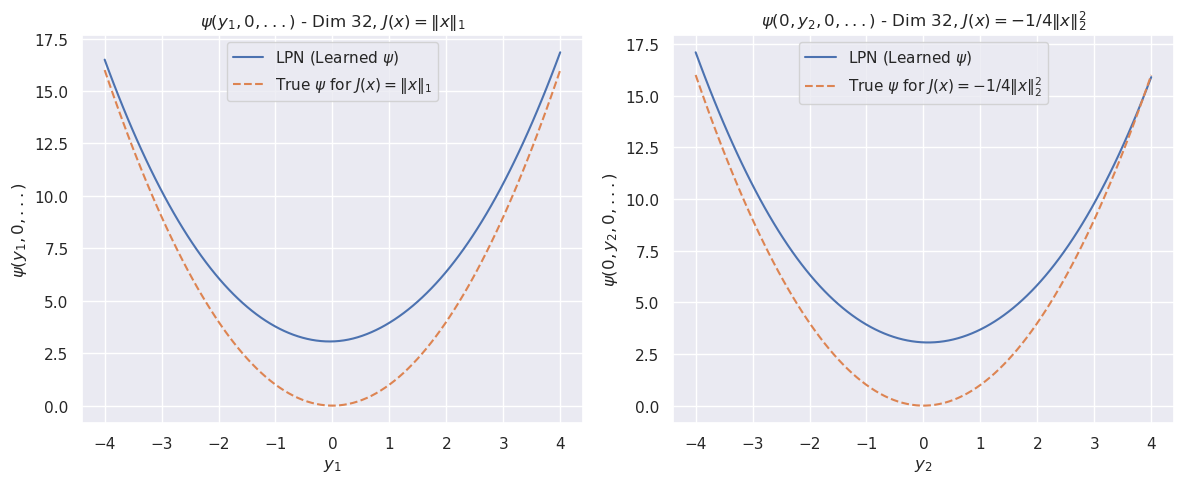

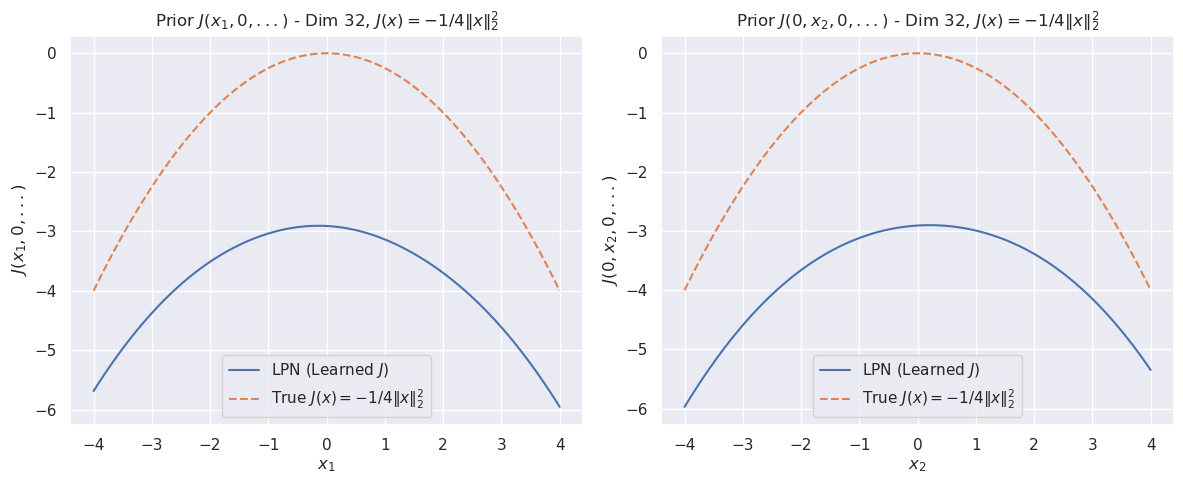

In [8]:
#print("\n--- Plotting Cross Sections for Quadratic H, Concave Quad Prior (Dim=4) ---")
plot_all_concave_quad(lpn_model_concave_quad_l2, a_exp, spacing, INVERT_MODE, dim_exp)

#print("\n--- Plotting Learned Hamiltonian for Quadratic H, Concave Quad Prior ---")
#evaluate_learned_H(lpn_model_concave_quad_l2, a_exp, spacing, dim_exp)

In [9]:
# --- Generate New Training Data for the Second LPN ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = y_j_exp_tensor.clone().to(device)
x_k_tensor.requires_grad_(True)

# Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model_concave_quad_l2.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model_concave_quad_l2(x_k_tensor)

# Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)


tensor([[-1.1328,  2.9096, -7.5971,  ...,  6.0357, -5.8822, -1.6331],
        [ 6.7870, -0.1100,  2.8218,  ..., -1.8949,  2.6823, -1.3726],
        [-7.5943,  1.2049,  2.5812,  ...,  0.8893, -1.3826, -4.4989],
        ...,
        [-5.5851,  5.1038,  7.1839,  ...,  0.2896,  0.5639,  0.4279],
        [ 0.1803, -6.2730,  5.5897,  ..., -3.1118, -2.4758,  6.1171],
        [-7.4316, -5.0341, -3.7985,  ..., -2.5845,  0.2153, -0.9667]],
       device='cuda:0')

In [10]:
# --- Train 2nd LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
lpn_model_G = LPN(in_dim=dim_exp, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-3)

for i in range(1):
     single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-3 
for i in range(iterations_exp_long):
    if (i % 100000 == 0) and (i > 0): 
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points_exp, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of 2nd LPN complete and model saved.")


--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 27490.859375
iteration 0 loss 10217.9228515625


iteration 500 loss 106.90339660644531


iteration 1000 loss 94.97843170166016


iteration 1500 loss 83.84488677978516


iteration 2000 loss 71.24365997314453


iteration 2500 loss 47.4804801940918


iteration 3000 loss 20.620622634887695


iteration 3500 loss 8.375727653503418


iteration 4000 loss 6.035832405090332


iteration 4500 loss 4.505565643310547


iteration 5000 loss 4.29997444152832


iteration 5500 loss 3.479292392730713


iteration 6000 loss 2.913599967956543


iteration 6500 loss 2.431760311126709


iteration 7000 loss 2.6881327629089355


iteration 7500 loss 2.2605490684509277


iteration 8000 loss 2.0035741329193115


iteration 8500 loss 1.788364052772522


iteration 9000 loss 1.9710601568222046


iteration 9500 loss 1.6430832147598267


iteration 10000 loss 1.4912763833999634


iteration 10500 loss 1.3609488010406494


iteration 11000 loss 1.4626156091690063


iteration 11500 loss 1.3045262098312378


iteration 12000 loss 1.202042579650879


iteration 12500 loss 1.596860647201538


iteration 13000 loss 1.1314345598220825


iteration 13500 loss 1.0489444732666016


iteration 14000 loss 10.256407737731934


iteration 14500 loss 1.071649193763733


iteration 15000 loss 0.9755519032478333


iteration 15500 loss 0.9148867130279541


iteration 16000 loss 1.6906987428665161


iteration 16500 loss 0.9094868898391724


iteration 17000 loss 0.8451284766197205


iteration 17500 loss 0.7994362115859985


iteration 18000 loss 0.8764067888259888


iteration 18500 loss 0.7898180484771729


iteration 19000 loss 0.7466246485710144


iteration 19500 loss 0.8351792693138123


iteration 20000 loss 0.7175846099853516


iteration 20500 loss 0.6818065047264099


iteration 21000 loss 0.6966915726661682


iteration 21500 loss 0.6502266526222229


iteration 22000 loss 0.8139275312423706


iteration 22500 loss 0.6378490328788757


iteration 23000 loss 0.6053071618080139


iteration 23500 loss 0.5912838578224182


iteration 24000 loss 0.7457571029663086


iteration 24500 loss 0.5721776485443115


iteration 25000 loss 0.5491058230400085


iteration 25500 loss 0.5400493741035461


iteration 26000 loss 0.6064010858535767


iteration 26500 loss 0.5177004933357239


iteration 27000 loss 1.7696433067321777


iteration 27500 loss 0.4997158646583557


iteration 28000 loss 0.6528617143630981


iteration 28500 loss 0.47536247968673706


iteration 29000 loss 0.4686523675918579


iteration 29500 loss 0.4905334711074829


iteration 30000 loss 0.4472237229347229


iteration 30500 loss 0.4521160423755646


iteration 31000 loss 0.6472525000572205


iteration 31500 loss 0.4215722680091858


iteration 32000 loss 0.4162349998950958


iteration 32500 loss 0.4141916036605835


iteration 33000 loss 0.4082145094871521


iteration 33500 loss 0.4000363051891327


iteration 34000 loss 0.39516890048980713


iteration 34500 loss 0.4234301745891571


iteration 35000 loss 0.37602099776268005


iteration 35500 loss 0.3698550760746002


iteration 36000 loss 0.3630509078502655


iteration 36500 loss 0.41028261184692383


iteration 37000 loss 0.5786012411117554


iteration 37500 loss 0.34742873907089233


iteration 38000 loss 0.34232473373413086


iteration 38500 loss 0.3527732789516449


iteration 39000 loss 0.3480220437049866


iteration 39500 loss 0.34432294964790344


iteration 40000 loss 0.32674774527549744


iteration 40500 loss 0.31836000084877014


iteration 41000 loss 10.401058197021484


iteration 41500 loss 0.3148532509803772


iteration 42000 loss 0.3116599917411804


iteration 42500 loss 0.3034862279891968


iteration 43000 loss 0.2977791130542755


iteration 43500 loss 0.3459847867488861


iteration 44000 loss 0.2920377254486084


iteration 44500 loss 0.288159042596817


iteration 45000 loss 0.2826912999153137


iteration 45500 loss 0.5182934403419495


iteration 46000 loss 0.28222283720970154


iteration 46500 loss 0.27399691939353943


iteration 47000 loss 0.2899278402328491


iteration 47500 loss 0.2659541666507721


iteration 48000 loss 0.26670601963996887


iteration 48500 loss 0.25910845398902893


iteration 49000 loss 0.2765503227710724


iteration 49500 loss 0.25287920236587524


iteration 50000 loss 0.2552054524421692


iteration 50500 loss 0.24695494771003723


iteration 51000 loss 0.251398503780365


iteration 51500 loss 0.24154606461524963


iteration 52000 loss 0.37244436144828796


iteration 52500 loss 0.23756366968154907


iteration 53000 loss 0.5040076971054077


iteration 53500 loss 0.23282450437545776


iteration 54000 loss 0.2586706280708313


iteration 54500 loss 0.2307836413383484


iteration 55000 loss 0.22471456229686737


iteration 55500 loss 1.2532403469085693


iteration 56000 loss 0.21904991567134857


iteration 56500 loss 0.2220294326543808


iteration 57000 loss 0.21458864212036133


iteration 57500 loss 0.24136656522750854


iteration 58000 loss 0.2192334681749344


iteration 58500 loss 0.21189084649085999


iteration 59000 loss 0.20684213936328888


iteration 59500 loss 0.2103319764137268


iteration 60000 loss 0.20494160056114197


iteration 60500 loss 0.21410804986953735


iteration 61000 loss 0.19920708239078522


iteration 61500 loss 1.1322110891342163


iteration 62000 loss 0.19649653136730194


iteration 62500 loss 0.20380575954914093


iteration 63000 loss 0.1906074583530426


iteration 63500 loss 0.556991696357727


iteration 64000 loss 0.19023679196834564


iteration 64500 loss 0.18602058291435242


iteration 65000 loss 0.19143521785736084


iteration 65500 loss 0.1863119751214981


iteration 66000 loss 0.18215633928775787


iteration 66500 loss 0.1815270185470581


iteration 67000 loss 1.3504204750061035


iteration 67500 loss 0.17716354131698608


iteration 68000 loss 0.17871317267417908


iteration 68500 loss 0.17482128739356995


iteration 69000 loss 0.18315930664539337


iteration 69500 loss 0.17268851399421692


iteration 70000 loss 0.2918228805065155


iteration 70500 loss 0.16756132245063782


iteration 71000 loss 0.16920436918735504


iteration 71500 loss 0.2935764193534851


iteration 72000 loss 0.16384367644786835


iteration 72500 loss 0.16590340435504913


iteration 73000 loss 7.944762229919434


iteration 73500 loss 0.15931743383407593


iteration 74000 loss 0.15771974623203278


iteration 74500 loss 0.15749698877334595


iteration 75000 loss 0.1601441204547882


iteration 75500 loss 0.1550769954919815


iteration 76000 loss 0.18252697587013245


iteration 76500 loss 0.15223756432533264


iteration 77000 loss 0.3566409945487976


iteration 77500 loss 0.18483029305934906


iteration 78000 loss 0.1480579972267151


iteration 78500 loss 0.14994457364082336


iteration 79000 loss 0.1458187997341156


iteration 79500 loss 1.076992154121399


iteration 80000 loss 0.14493225514888763


iteration 80500 loss 0.14319218695163727


iteration 81000 loss 0.14257292449474335


iteration 81500 loss 0.1421298235654831


iteration 82000 loss 0.1678864061832428


iteration 82500 loss 0.2957767844200134


iteration 83000 loss 11.686034202575684


iteration 83500 loss 0.8226701021194458


iteration 84000 loss 0.13557612895965576


iteration 84500 loss 0.13490185141563416


iteration 85000 loss 0.13490822911262512


iteration 85500 loss 3.698942184448242


iteration 86000 loss 0.1320141851902008


iteration 86500 loss 0.13389170169830322


iteration 87000 loss 0.12979306280612946


iteration 87500 loss 0.13577669858932495


iteration 88000 loss 0.13721464574337006


iteration 88500 loss 0.12657751142978668


iteration 89000 loss 0.1272873431444168


iteration 89500 loss 0.1278451383113861


iteration 90000 loss 3.6183905601501465


iteration 90500 loss 0.420337975025177


iteration 91000 loss 1.7651798725128174


iteration 91500 loss 0.20646952092647552


iteration 92000 loss 0.17093822360038757


iteration 92500 loss 0.5908287167549133


iteration 93000 loss 0.13973011076450348


iteration 93500 loss 2.583413600921631


iteration 94000 loss 0.11773297190666199


iteration 94500 loss 0.11718375980854034


iteration 95000 loss 0.11731024831533432


iteration 95500 loss 0.2698034346103668


iteration 96000 loss 0.11647078394889832


iteration 96500 loss 0.11554296314716339


iteration 97000 loss 0.11394311487674713


iteration 97500 loss 0.12081997096538544


iteration 98000 loss 0.1121920645236969


iteration 98500 loss 0.1122693419456482


iteration 99000 loss 0.1314527988433838


iteration 99500 loss 0.1315823793411255


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 14.629755973815918


iteration 100500 loss 0.10904806852340698


iteration 101000 loss 0.10832414031028748


iteration 101500 loss 0.10775206238031387


iteration 102000 loss 0.10725288838148117


iteration 102500 loss 0.10676974803209305


iteration 103000 loss 0.10626102238893509


iteration 103500 loss 0.10569899529218674


iteration 104000 loss 0.10505922883749008


iteration 104500 loss 0.10431624203920364


iteration 105000 loss 0.10344794392585754


iteration 105500 loss 0.10279428213834763


iteration 106000 loss 0.10348895937204361


iteration 106500 loss 0.10141106694936752


iteration 107000 loss 0.10081879794597626


iteration 107500 loss 0.10421678423881531


iteration 108000 loss 0.09953819960355759


iteration 108500 loss 0.09922938793897629


iteration 109000 loss 0.09833391010761261


iteration 109500 loss 0.09779764711856842


iteration 110000 loss 0.09779231250286102


iteration 110500 loss 0.09662807732820511


iteration 111000 loss 0.09604720026254654


iteration 111500 loss 0.09553667902946472


iteration 112000 loss 0.1009000912308693


iteration 112500 loss 0.09446953237056732


iteration 113000 loss 0.09402921050786972


iteration 113500 loss 0.09342045336961746


iteration 114000 loss 0.09291055798530579


iteration 114500 loss 0.0924079418182373


iteration 115000 loss 0.09195548295974731


iteration 115500 loss 0.09241392463445663


iteration 116000 loss 0.09097672998905182


iteration 116500 loss 0.09060616791248322


iteration 117000 loss 0.09001953899860382


iteration 117500 loss 0.08971656113862991


iteration 118000 loss 0.08908803761005402


iteration 118500 loss 0.08864405006170273


iteration 119000 loss 0.08820772171020508


iteration 119500 loss 0.08775617182254791


iteration 120000 loss 0.09263303130865097


iteration 120500 loss 0.0868775025010109


iteration 121000 loss 0.08642526715993881


iteration 121500 loss 0.08601444959640503


iteration 122000 loss 0.08951731026172638


iteration 122500 loss 0.08517049252986908


iteration 123000 loss 0.08476592600345612


iteration 123500 loss 0.0843408927321434


iteration 124000 loss 0.0844147652387619


iteration 124500 loss 0.08353515714406967


iteration 125000 loss 0.08315709233283997


iteration 125500 loss 0.08274827897548676


iteration 126000 loss 0.0823800265789032


iteration 126500 loss 0.08199252933263779


iteration 127000 loss 0.08159978687763214


iteration 127500 loss 0.08120571821928024


iteration 128000 loss 0.08084265142679214


iteration 128500 loss 0.08052300661802292


iteration 129000 loss 0.08035114407539368


iteration 129500 loss 0.07974371314048767


iteration 130000 loss 0.07968369126319885


iteration 130500 loss 0.07902917265892029


iteration 131000 loss 0.07873053848743439


iteration 131500 loss 0.07829169183969498


iteration 132000 loss 0.07798104733228683


iteration 132500 loss 0.07766865193843842


iteration 133000 loss 0.07727885246276855


iteration 133500 loss 0.076947420835495


iteration 134000 loss 0.07760075479745865


iteration 134500 loss 0.0762510821223259


iteration 135000 loss 0.07596252858638763


iteration 135500 loss 0.07557068020105362


iteration 136000 loss 0.07789420336484909


iteration 136500 loss 0.07490712404251099


iteration 137000 loss 0.07461993396282196


iteration 137500 loss 0.07426045089960098


iteration 138000 loss 0.07397855073213577


iteration 138500 loss 0.07364179193973541


iteration 139000 loss 0.07333841919898987


iteration 139500 loss 0.07414870709180832


iteration 140000 loss 0.07270809262990952


iteration 140500 loss 0.07239370793104172


iteration 141000 loss 0.07212765514850616


iteration 141500 loss 0.07180145382881165


iteration 142000 loss 0.07187105715274811


iteration 142500 loss 0.07119399309158325


iteration 143000 loss 0.07438809424638748


iteration 143500 loss 0.070594422519207


iteration 144000 loss 0.07030653208494186


iteration 144500 loss 0.07007507234811783


iteration 145000 loss 0.06973115354776382


iteration 145500 loss 0.06941095739603043


iteration 146000 loss 0.06916391104459763


iteration 146500 loss 0.06889244168996811


iteration 147000 loss 0.06993667781352997


iteration 147500 loss 0.06835182011127472


iteration 148000 loss 0.06807020306587219


iteration 148500 loss 0.06780298799276352


iteration 149000 loss 0.06870429217815399


iteration 149500 loss 0.06726480275392532


iteration 150000 loss 0.06699533015489578


iteration 150500 loss 0.06674860417842865


iteration 151000 loss 0.0664990246295929


iteration 151500 loss 0.06624936312437057


iteration 152000 loss 0.065979965031147


iteration 152500 loss 0.06639202684164047


iteration 153000 loss 0.06546194851398468


iteration 153500 loss 0.06532555818557739


iteration 154000 loss 0.0649728998541832


iteration 154500 loss 0.06477022171020508


iteration 155000 loss 0.06448200345039368


iteration 155500 loss 0.06458951532840729


iteration 156000 loss 0.0699274018406868


iteration 156500 loss 0.06377360224723816


iteration 157000 loss 0.06351222842931747


iteration 157500 loss 0.06330063194036484


iteration 158000 loss 0.06306356936693192


iteration 158500 loss 0.0628344938158989


iteration 159000 loss 0.06670521944761276


iteration 159500 loss 0.062370821833610535


iteration 160000 loss 0.06214234605431557


iteration 160500 loss 0.0619782991707325


iteration 161000 loss 0.06169000267982483


iteration 161500 loss 0.06148144230246544


iteration 162000 loss 0.061237070709466934


iteration 162500 loss 0.061045799404382706


iteration 163000 loss 0.060819730162620544


iteration 163500 loss 0.06060795858502388


iteration 164000 loss 0.06134399399161339


iteration 164500 loss 0.060176782310009


iteration 165000 loss 0.061824578791856766


iteration 165500 loss 0.05976225435733795


iteration 166000 loss 0.05963270738720894


iteration 166500 loss 0.059344738721847534


iteration 167000 loss 0.06016480550169945


iteration 167500 loss 0.05893221125006676


iteration 168000 loss 0.06426109373569489


iteration 168500 loss 0.05853217467665672


iteration 169000 loss 0.05833403021097183


iteration 169500 loss 0.05813328176736832


iteration 170000 loss 0.058032501488924026


iteration 170500 loss 0.05774136632680893


iteration 171000 loss 0.057542819529771805


iteration 171500 loss 0.05734510347247124


iteration 172000 loss 0.29101258516311646


iteration 172500 loss 0.056971386075019836


iteration 173000 loss 0.056814927607774734


iteration 173500 loss 0.056593552231788635


iteration 174000 loss 0.05640166625380516


iteration 174500 loss 0.05622027441859245


iteration 175000 loss 0.05608470365405083


iteration 175500 loss 0.05585344135761261


iteration 176000 loss 0.05567101761698723


iteration 176500 loss 0.055540215224027634


iteration 177000 loss 0.05532349646091461


iteration 177500 loss 0.055134233087301254


iteration 178000 loss 0.05496111884713173


iteration 178500 loss 0.05475790798664093


iteration 179000 loss 0.05461901053786278


iteration 179500 loss 0.05448189377784729


iteration 180000 loss 0.054273393005132675


iteration 180500 loss 0.05408366024494171


iteration 181000 loss 0.053929321467876434


iteration 181500 loss 0.05374833941459656


iteration 182000 loss 0.053595803678035736


iteration 182500 loss 0.053434159606695175


iteration 183000 loss 0.32485097646713257


iteration 183500 loss 0.053105827420949936


iteration 184000 loss 0.05347719416022301


iteration 184500 loss 0.05279070883989334


iteration 185000 loss 0.05300435796380043


iteration 185500 loss 0.052481986582279205


iteration 186000 loss 0.055289238691329956


iteration 186500 loss 0.052127398550510406


iteration 187000 loss 0.05195305123925209


iteration 187500 loss 0.0518033541738987


iteration 188000 loss 0.05169089138507843


iteration 188500 loss 0.0514865480363369


iteration 189000 loss 0.051334116607904434


iteration 189500 loss 0.051953911781311035


iteration 190000 loss 0.051021281629800797


iteration 190500 loss 0.05086836218833923


iteration 191000 loss 0.050711121410131454


iteration 191500 loss 0.05227978900074959


iteration 192000 loss 0.05040697753429413


iteration 192500 loss 0.6335219144821167


iteration 193000 loss 0.050105515867471695


iteration 193500 loss 0.049963146448135376


iteration 194000 loss 0.049810051918029785


iteration 194500 loss 0.04965285211801529


iteration 195000 loss 0.04970984533429146


iteration 195500 loss 0.049364376813173294


iteration 196000 loss 0.04921060800552368


iteration 196500 loss 0.04908166080713272


iteration 197000 loss 0.049036458134651184


iteration 197500 loss 0.048797957599163055


iteration 198000 loss 0.048647526651620865


iteration 198500 loss 0.048516519367694855


iteration 199000 loss 0.04838290438055992


iteration 199500 loss 0.048233017325401306


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.048088040202856064


iteration 200500 loss 0.048065584152936935


iteration 201000 loss 0.04804269224405289


iteration 201500 loss 0.048013318330049515


iteration 202000 loss 0.047975651919841766


iteration 202500 loss 0.04792722687125206


iteration 203000 loss 0.047865256667137146


iteration 203500 loss 0.047785960137844086


iteration 204000 loss 0.04768442362546921


iteration 204500 loss 0.04755477234721184


iteration 205000 loss 0.04739648848772049


iteration 205500 loss 0.04721255227923393


iteration 206000 loss 0.047129057347774506


iteration 206500 loss 0.04703768342733383


iteration 207000 loss 0.046924542635679245


iteration 207500 loss 0.046782445162534714


iteration 208000 loss 0.04660026729106903


iteration 208500 loss 0.04650302976369858


iteration 209000 loss 0.04641955718398094


iteration 209500 loss 0.046317700296640396


iteration 210000 loss 0.046185802668333054


iteration 210500 loss 0.04601519927382469


iteration 211000 loss 0.04587997868657112


iteration 211500 loss 0.0458085834980011


iteration 212000 loss 0.045717425644397736


iteration 212500 loss 0.04561229050159454


iteration 213000 loss 0.045464929193258286


iteration 213500 loss 0.04528030380606651


iteration 214000 loss 0.045194510370492935


iteration 214500 loss 0.04509905353188515


iteration 215000 loss 0.04498203098773956


iteration 215500 loss 0.044833969324827194


iteration 216000 loss 0.04468798264861107


iteration 216500 loss 0.04461299255490303


iteration 217000 loss 0.044517382979393005


iteration 217500 loss 0.0443967841565609


iteration 218000 loss 0.04424486309289932


iteration 218500 loss 0.04411272704601288


iteration 219000 loss 0.04403411224484444


iteration 219500 loss 0.04393495246767998


iteration 220000 loss 0.04381095990538597


iteration 220500 loss 0.04365464299917221


iteration 221000 loss 0.043569210916757584


iteration 221500 loss 0.043492767959833145


iteration 222000 loss 0.04339882731437683


iteration 222500 loss 0.04327564686536789


iteration 223000 loss 0.04312201961874962


iteration 223500 loss 0.04302455484867096


iteration 224000 loss 0.0429547019302845


iteration 224500 loss 0.04286566749215126


iteration 225000 loss 0.04275582730770111


iteration 225500 loss 0.0426216647028923


iteration 226000 loss 0.042485445737838745


iteration 226500 loss 0.04241378605365753


iteration 227000 loss 0.042325425893068314


iteration 227500 loss 0.04220717027783394


iteration 228000 loss 0.04206489026546478


iteration 228500 loss 0.04195928946137428


iteration 229000 loss 0.04189101979136467


iteration 229500 loss 0.04180411249399185


iteration 230000 loss 0.04169406741857529


iteration 230500 loss 0.04155733063817024


iteration 231000 loss 0.04144037514925003


iteration 231500 loss 0.04137241840362549


iteration 232000 loss 0.041285641491413116


iteration 232500 loss 0.041177403181791306


iteration 233000 loss 0.04104812815785408


iteration 233500 loss 0.040957462042570114


iteration 234000 loss 0.04087407514452934


iteration 234500 loss 0.04077230766415596


iteration 235000 loss 0.04064245522022247


iteration 235500 loss 0.04054250940680504


iteration 236000 loss 0.0404813177883625


iteration 236500 loss 0.040403127670288086


iteration 237000 loss 0.04032540321350098


iteration 237500 loss 0.04018836095929146


iteration 238000 loss 0.04005175083875656


iteration 238500 loss 0.03999713435769081


iteration 239000 loss 0.03992937505245209


iteration 239500 loss 0.0398428812623024


iteration 240000 loss 0.03973570466041565


iteration 240500 loss 0.03959859535098076


iteration 241000 loss 0.039517950266599655


iteration 241500 loss 0.03945271670818329


iteration 242000 loss 0.039369892328977585


iteration 242500 loss 0.039264336228370667


iteration 243000 loss 0.03913729265332222


iteration 243500 loss 0.03905091434717178


iteration 244000 loss 0.038981370627880096


iteration 244500 loss 0.038894250988960266


iteration 245000 loss 0.038783472031354904


iteration 245500 loss 0.044417623430490494


iteration 246000 loss 0.03859832137823105


iteration 246500 loss 0.038541316986083984


iteration 247000 loss 0.038468558341264725


iteration 247500 loss 0.038381073623895645


iteration 248000 loss 0.03826456889510155


iteration 248500 loss 0.03815323859453201


iteration 249000 loss 0.03810201957821846


iteration 249500 loss 0.03803706541657448


iteration 250000 loss 0.037955816835165024


iteration 250500 loss 0.03786163032054901


iteration 251000 loss 0.03772125765681267


iteration 251500 loss 0.03766188398003578


iteration 252000 loss 0.03759779408574104


iteration 252500 loss 0.03751751035451889


iteration 253000 loss 0.037423547357320786


iteration 253500 loss 0.03728538006544113


iteration 254000 loss 0.037223175168037415


iteration 254500 loss 0.037159524857997894


iteration 255000 loss 0.037094712257385254


iteration 255500 loss 0.03699009120464325


iteration 256000 loss 0.03687393665313721


iteration 256500 loss 0.03679697960615158


iteration 257000 loss 0.03673231974244118


iteration 257500 loss 0.03665550425648689


iteration 258000 loss 0.03656341880559921


iteration 258500 loss 0.03643937408924103


iteration 259000 loss 0.03638201206922531


iteration 259500 loss 0.03632139042019844


iteration 260000 loss 0.03624492883682251


iteration 260500 loss 0.03615129739046097


iteration 261000 loss 0.03628217801451683


iteration 261500 loss 0.03598086163401604


iteration 262000 loss 0.035920318216085434


iteration 262500 loss 0.03585410490632057


iteration 263000 loss 0.03574714437127113


iteration 263500 loss 0.03831323981285095


iteration 264000 loss 0.035581473261117935


iteration 264500 loss 0.03552307188510895


iteration 265000 loss 0.035450279712677


iteration 265500 loss 0.035361774265766144


iteration 266000 loss 0.035247497260570526


iteration 266500 loss 0.03519293665885925


iteration 267000 loss 0.035145651549100876


iteration 267500 loss 0.035086169838905334


iteration 268000 loss 0.03500931337475777


iteration 268500 loss 0.03492002934217453


iteration 269000 loss 0.03481758385896683


iteration 269500 loss 0.03476677089929581


iteration 270000 loss 0.03470437601208687


iteration 270500 loss 0.034622061997652054


iteration 271000 loss 0.0345279760658741


iteration 271500 loss 0.03444100171327591


iteration 272000 loss 0.034393079578876495


iteration 272500 loss 0.0343317948281765


iteration 273000 loss 0.03425893560051918


iteration 273500 loss 0.03416837751865387


iteration 274000 loss 0.03407511115074158


iteration 274500 loss 0.03403598815202713


iteration 275000 loss 0.03398605436086655


iteration 275500 loss 0.033923111855983734


iteration 276000 loss 0.03385624662041664


iteration 276500 loss 0.03375619277358055


iteration 277000 loss 0.03367544338107109


iteration 277500 loss 0.03362392634153366


iteration 278000 loss 0.03356008976697922


iteration 278500 loss 0.033476244658231735


iteration 279000 loss 0.03337864205241203


iteration 279500 loss 0.033321939408779144


iteration 280000 loss 0.0332769900560379


iteration 280500 loss 0.03321949392557144


iteration 281000 loss 0.03315170854330063


iteration 281500 loss 0.03306042402982712


iteration 282000 loss 0.032985687255859375


iteration 282500 loss 0.032936468720436096


iteration 283000 loss 0.03287629783153534


iteration 283500 loss 0.0328054204583168


iteration 284000 loss 0.032705627381801605


iteration 284500 loss 0.03264198452234268


iteration 285000 loss 0.03259233757853508


iteration 285500 loss 0.03252937272191048


iteration 286000 loss 0.032453153282403946


iteration 286500 loss 0.03242185711860657


iteration 287000 loss 0.032315678894519806


iteration 287500 loss 0.032275550067424774


iteration 288000 loss 0.032224126160144806


iteration 288500 loss 0.03216413035988808


iteration 289000 loss 0.03208012506365776


iteration 289500 loss 0.03199244290590286


iteration 290000 loss 0.031948767602443695


iteration 290500 loss 0.03189358115196228


iteration 291000 loss 0.031841941177845


iteration 291500 loss 0.031743623316287994


iteration 292000 loss 0.031667087227106094


iteration 292500 loss 0.03163371980190277


iteration 293000 loss 0.03159133717417717


iteration 293500 loss 0.03154566511511803


iteration 294000 loss 0.03147111088037491


iteration 294500 loss 0.03138741850852966


iteration 295000 loss 0.03131555765867233


iteration 295500 loss 0.03128267824649811


iteration 296000 loss 0.03124091774225235


iteration 296500 loss 0.031188903376460075


iteration 297000 loss 0.031123772263526917


iteration 297500 loss 0.031038586050271988


iteration 298000 loss 0.03098577819764614


iteration 298500 loss 0.030945036560297012


iteration 299000 loss 0.030892858281731606


iteration 299500 loss 0.030827660113573074


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.0307683777064085


iteration 300500 loss 0.030732475221157074


iteration 301000 loss 0.03071899339556694


iteration 301500 loss 0.0307016558945179


iteration 302000 loss 0.030679473653435707


iteration 302500 loss 0.03065093606710434


iteration 303000 loss 0.030614443123340607


iteration 303500 loss 0.03056780993938446


iteration 304000 loss 0.030508697032928467


iteration 304500 loss 0.030434124171733856


iteration 305000 loss 0.03034219890832901


iteration 305500 loss 0.030248800292611122


iteration 306000 loss 0.030152080580592155


iteration 306500 loss 0.030057353898882866


iteration 307000 loss 0.029963253065943718


iteration 307500 loss 0.029872484505176544


iteration 308000 loss 0.029780492186546326


iteration 308500 loss 0.02968575991690159


iteration 309000 loss 0.0295942984521389


iteration 309500 loss 0.029502535238862038


iteration 310000 loss 0.029413430020213127


iteration 310500 loss 0.029331840574741364


iteration 311000 loss 0.029242150485515594


iteration 311500 loss 0.029151421040296555


iteration 312000 loss 0.02906215749680996


iteration 312500 loss 0.028976967558264732


iteration 313000 loss 0.028889158740639687


iteration 313500 loss 0.02880244143307209


iteration 314000 loss 0.028722526505589485


iteration 314500 loss 0.028638705611228943


iteration 315000 loss 0.028550701215863228


iteration 315500 loss 0.02846558205783367


iteration 316000 loss 0.02838733419775963


iteration 316500 loss 0.028303734958171844


iteration 317000 loss 0.02821953035891056


iteration 317500 loss 0.028134401887655258


iteration 318000 loss 0.028053026646375656


iteration 318500 loss 0.027971141040325165


iteration 319000 loss 0.027896571904420853


iteration 319500 loss 0.02781854197382927


iteration 320000 loss 0.027736186981201172


iteration 320500 loss 0.02765323407948017


iteration 321000 loss 0.027572594583034515


iteration 321500 loss 0.027492333203554153


iteration 322000 loss 0.027412788942456245


iteration 322500 loss 0.027331335470080376


iteration 323000 loss 0.027253612875938416


iteration 323500 loss 0.027178198099136353


iteration 324000 loss 0.027098296210169792


iteration 324500 loss 0.0270198043435812


iteration 325000 loss 0.02694246731698513


iteration 325500 loss 0.026863519102334976


iteration 326000 loss 0.0267882589250803


iteration 326500 loss 0.026713762432336807


iteration 327000 loss 0.026644926518201828


iteration 327500 loss 0.026572106406092644


iteration 328000 loss 0.026495156809687614


iteration 328500 loss 0.026422306895256042


iteration 329000 loss 0.026348402723670006


iteration 329500 loss 0.02627464011311531


iteration 330000 loss 0.026205087080597878


iteration 330500 loss 0.02613707259297371


iteration 331000 loss 0.0260638240724802


iteration 331500 loss 0.025994740426540375


iteration 332000 loss 0.02592342533171177


iteration 332500 loss 0.025852959603071213


iteration 333000 loss 0.025781024247407913


iteration 333500 loss 0.02571318857371807


iteration 334000 loss 0.025640588253736496


iteration 334500 loss 0.025571448728442192


iteration 335000 loss 0.02550027333199978


iteration 335500 loss 0.02542838081717491


iteration 336000 loss 0.025356365367770195


iteration 336500 loss 0.02529807761311531


iteration 337000 loss 0.02522905543446541


iteration 337500 loss 0.025158556178212166


iteration 338000 loss 0.025096312165260315


iteration 338500 loss 0.02504081279039383


iteration 339000 loss 0.024963106960058212


iteration 339500 loss 0.024896780028939247


iteration 340000 loss 0.024832867085933685


iteration 340500 loss 0.024764182046055794


iteration 341000 loss 0.02470599301159382


iteration 341500 loss 0.024652399122714996


iteration 342000 loss 0.02457999624311924


iteration 342500 loss 0.024512290954589844


iteration 343000 loss 0.02445191890001297


iteration 343500 loss 0.024387504905462265


iteration 344000 loss 0.02432727813720703


iteration 344500 loss 0.02426600269973278


iteration 345000 loss 0.024202678352594376


iteration 345500 loss 0.024140579625964165


iteration 346000 loss 0.024081069976091385


iteration 346500 loss 0.024019142612814903


iteration 347000 loss 0.023958589881658554


iteration 347500 loss 0.023896243423223495


iteration 348000 loss 0.023842262104153633


iteration 348500 loss 0.023783277720212936


iteration 349000 loss 0.023726245388388634


iteration 349500 loss 0.02366248145699501


iteration 350000 loss 0.02360638603568077


iteration 350500 loss 0.0235411636531353


iteration 351000 loss 0.023485194891691208


iteration 351500 loss 0.02342594973742962


iteration 352000 loss 0.023362798616290092


iteration 352500 loss 0.023303136229515076


iteration 353000 loss 0.02325226180255413


iteration 353500 loss 0.023192148655653


iteration 354000 loss 0.023138100281357765


iteration 354500 loss 0.02308039553463459


iteration 355000 loss 0.023021874949336052


iteration 355500 loss 0.022971156984567642


iteration 356000 loss 0.0229166429489851


iteration 356500 loss 0.02286204881966114


iteration 357000 loss 0.022822178900241852


iteration 357500 loss 0.022752519696950912


iteration 358000 loss 0.022697070613503456


iteration 358500 loss 0.022640299052000046


iteration 359000 loss 0.022583328187465668


iteration 359500 loss 0.022531377151608467


iteration 360000 loss 0.022473791614174843


iteration 360500 loss 0.02242056094110012


iteration 361000 loss 0.02236238867044449


iteration 361500 loss 0.022306814789772034


iteration 362000 loss 0.02225559391081333


iteration 362500 loss 0.022198548540472984


iteration 363000 loss 0.02215086668729782


iteration 363500 loss 0.022094905376434326


iteration 364000 loss 0.022043144330382347


iteration 364500 loss 0.021995235234498978


iteration 365000 loss 0.021950097754597664


iteration 365500 loss 0.02189633809030056


iteration 366000 loss 0.021851856261491776


iteration 366500 loss 0.021797986701130867


iteration 367000 loss 0.02174210734665394


iteration 367500 loss 0.02169737219810486


iteration 368000 loss 0.021643267944455147


iteration 368500 loss 0.021594062447547913


iteration 369000 loss 0.02153935842216015


iteration 369500 loss 0.0214933343231678


iteration 370000 loss 0.021442202851176262


iteration 370500 loss 0.021392224356532097


iteration 371000 loss 0.021345803514122963


iteration 371500 loss 0.021297359839081764


iteration 372000 loss 0.021250329911708832


iteration 372500 loss 0.02119792066514492


iteration 373000 loss 0.021156776696443558


iteration 373500 loss 0.02110707201063633


iteration 374000 loss 0.021063756197690964


iteration 374500 loss 0.021019501611590385


iteration 375000 loss 0.02097158692777157


iteration 375500 loss 0.020929638296365738


iteration 376000 loss 0.020879199728369713


iteration 376500 loss 0.0208301804959774


iteration 377000 loss 0.020790956914424896


iteration 377500 loss 0.020742245018482208


iteration 378000 loss 0.020697223022580147


iteration 378500 loss 0.020650969818234444


iteration 379000 loss 0.020605335012078285


iteration 379500 loss 0.020555419847369194


iteration 380000 loss 0.020513003692030907


iteration 380500 loss 0.020465826615691185


iteration 381000 loss 0.02042340859770775


iteration 381500 loss 0.020375674590468407


iteration 382000 loss 0.020333219319581985


iteration 382500 loss 0.02028837241232395


iteration 383000 loss 0.020245512947440147


iteration 383500 loss 0.02020319737493992


iteration 384000 loss 0.020162934437394142


iteration 384500 loss 0.02011650614440441


iteration 385000 loss 0.0200700294226408


iteration 385500 loss 0.020029332488775253


iteration 386000 loss 0.0199848935008049


iteration 386500 loss 0.01994485966861248


iteration 387000 loss 0.019899606704711914


iteration 387500 loss 0.019858354702591896


iteration 388000 loss 0.019811905920505524


iteration 388500 loss 0.0197694581001997


iteration 389000 loss 0.019729552790522575


iteration 389500 loss 0.019687511026859283


iteration 390000 loss 0.01964651048183441


iteration 390500 loss 0.01960246078670025


iteration 391000 loss 0.019557934254407883


iteration 391500 loss 0.019513970240950584


iteration 392000 loss 0.01947578601539135


iteration 392500 loss 0.019434327259659767


iteration 393000 loss 0.01939583756029606


iteration 393500 loss 0.01935492269694805


iteration 394000 loss 0.019316192716360092


iteration 394500 loss 0.019275814294815063


iteration 395000 loss 0.019229993224143982


iteration 395500 loss 0.019192839041352272


iteration 396000 loss 0.01915670372545719


iteration 396500 loss 0.019114574417471886


iteration 397000 loss 0.01907908171415329


iteration 397500 loss 0.019036434590816498


iteration 398000 loss 0.01900259591639042


iteration 398500 loss 0.01896080933511257


iteration 399000 loss 0.018926037475466728


iteration 399500 loss 0.018886055797338486


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.018849099054932594


iteration 400500 loss 0.01884508691728115


iteration 401000 loss 0.01884000562131405


iteration 401500 loss 0.01883360557258129


iteration 402000 loss 0.018825659528374672


iteration 402500 loss 0.018815912306308746


iteration 403000 loss 0.018804186955094337


iteration 403500 loss 0.018790382891893387


iteration 404000 loss 0.01877439022064209


iteration 404500 loss 0.018756315112113953


iteration 405000 loss 0.018736468628048897


iteration 405500 loss 0.01871512271463871


iteration 406000 loss 0.0186929814517498


iteration 406500 loss 0.01867094077169895


iteration 407000 loss 0.01864895038306713


iteration 407500 loss 0.01862710900604725


iteration 408000 loss 0.01860528439283371


iteration 408500 loss 0.018583569675683975


iteration 409000 loss 0.018561895936727524


iteration 409500 loss 0.018540354445576668


iteration 410000 loss 0.018518805503845215


iteration 410500 loss 0.018497349694371223


iteration 411000 loss 0.018475966528058052


iteration 411500 loss 0.018454628065228462


iteration 412000 loss 0.018433373421430588


iteration 412500 loss 0.01841212995350361


iteration 413000 loss 0.018390994518995285


iteration 413500 loss 0.0183698870241642


iteration 414000 loss 0.018348852172493935


iteration 414500 loss 0.018327824771404266


iteration 415000 loss 0.018306877464056015


iteration 415500 loss 0.018285976722836494


iteration 416000 loss 0.018265146762132645


iteration 416500 loss 0.01824428141117096


iteration 417000 loss 0.01822362095117569


iteration 417500 loss 0.018202899023890495


iteration 418000 loss 0.01818222552537918


iteration 418500 loss 0.01816163957118988


iteration 419000 loss 0.018141070380806923


iteration 419500 loss 0.018120557069778442


iteration 420000 loss 0.018100077286362648


iteration 420500 loss 0.018079642206430435


iteration 421000 loss 0.018059227615594864


iteration 421500 loss 0.018038878217339516


iteration 422000 loss 0.0180185679346323


iteration 422500 loss 0.01799832098186016


iteration 423000 loss 0.017978066578507423


iteration 423500 loss 0.01795784942805767


iteration 424000 loss 0.01793772168457508


iteration 424500 loss 0.017917577177286148


iteration 425000 loss 0.01789751462638378


iteration 425500 loss 0.017877468839287758


iteration 426000 loss 0.01785746030509472


iteration 426500 loss 0.01783747598528862


iteration 427000 loss 0.017817534506320953


iteration 427500 loss 0.017797643318772316


iteration 428000 loss 0.017777808010578156


iteration 428500 loss 0.017757941037416458


iteration 429000 loss 0.01773819327354431


iteration 429500 loss 0.01771841011941433


iteration 430000 loss 0.017698684707283974


iteration 430500 loss 0.01767902635037899


iteration 431000 loss 0.017659369856119156


iteration 431500 loss 0.01763976365327835


iteration 432000 loss 0.017620205879211426


iteration 432500 loss 0.0176006518304348


iteration 433000 loss 0.017581140622496605


iteration 433500 loss 0.01756165735423565


iteration 434000 loss 0.01754220761358738


iteration 434500 loss 0.01752280443906784


iteration 435000 loss 0.017503438517451286


iteration 435500 loss 0.01748410053551197


iteration 436000 loss 0.017464803531765938


iteration 436500 loss 0.017445510253310204


iteration 437000 loss 0.017426274716854095


iteration 437500 loss 0.017407070845365524


iteration 438000 loss 0.017387865111231804


iteration 438500 loss 0.017368720844388008


iteration 439000 loss 0.01734962686896324


iteration 439500 loss 0.01733052358031273


iteration 440000 loss 0.017311492934823036


iteration 440500 loss 0.01729249581694603


iteration 441000 loss 0.017273517325520515


iteration 441500 loss 0.01725454069674015


iteration 442000 loss 0.017235571518540382


iteration 442500 loss 0.017216652631759644


iteration 443000 loss 0.017197787761688232


iteration 443500 loss 0.01717895083129406


iteration 444000 loss 0.01716015860438347


iteration 444500 loss 0.01714138500392437


iteration 445000 loss 0.01712259091436863


iteration 445500 loss 0.017103901132941246


iteration 446000 loss 0.017085161060094833


iteration 446500 loss 0.017066488042473793


iteration 447000 loss 0.017047857865691185


iteration 447500 loss 0.017029259353876114


iteration 448000 loss 0.017010657116770744


iteration 448500 loss 0.016992129385471344


iteration 449000 loss 0.016973620280623436


iteration 449500 loss 0.016955126076936722


iteration 450000 loss 0.016936682164669037


iteration 450500 loss 0.016918258741497993


iteration 451000 loss 0.01689985580742359


iteration 451500 loss 0.016881506890058517


iteration 452000 loss 0.016863122582435608


iteration 452500 loss 0.016844820231199265


iteration 453000 loss 0.01682657189667225


iteration 453500 loss 0.016808263957500458


iteration 454000 loss 0.01679004542529583


iteration 454500 loss 0.016771841794252396


iteration 455000 loss 0.01675364375114441


iteration 455500 loss 0.016735509037971497


iteration 456000 loss 0.016717368736863136


iteration 456500 loss 0.016699258238077164


iteration 457000 loss 0.01668119989335537


iteration 457500 loss 0.016663165763020515


iteration 458000 loss 0.016645126044750214


iteration 458500 loss 0.01662716269493103


iteration 459000 loss 0.016609182581305504


iteration 459500 loss 0.016591284424066544


iteration 460000 loss 0.0165733490139246


iteration 460500 loss 0.01655547320842743


iteration 461000 loss 0.016537640243768692


iteration 461500 loss 0.01651977188885212


iteration 462000 loss 0.016501961275935173


iteration 462500 loss 0.01648421213030815


iteration 463000 loss 0.01646646298468113


iteration 463500 loss 0.016448745504021645


iteration 464000 loss 0.016431033611297607


iteration 464500 loss 0.016413375735282898


iteration 465000 loss 0.016395730897784233


iteration 465500 loss 0.016378091648221016


iteration 466000 loss 0.01636050082743168


iteration 466500 loss 0.01634293980896473


iteration 467000 loss 0.016325389966368675


iteration 467500 loss 0.016307828947901726


iteration 468000 loss 0.016290346160531044


iteration 468500 loss 0.01627286709845066


iteration 469000 loss 0.01625540852546692


iteration 469500 loss 0.016237976029515266


iteration 470000 loss 0.016220571473240852


iteration 470500 loss 0.016203204169869423


iteration 471000 loss 0.016185836866497993


iteration 471500 loss 0.016168519854545593


iteration 472000 loss 0.016151223331689835


iteration 472500 loss 0.016133975237607956


iteration 473000 loss 0.016116708517074585


iteration 473500 loss 0.016099432483315468


iteration 474000 loss 0.016082242131233215


iteration 474500 loss 0.01606503687798977


iteration 475000 loss 0.016047852113842964


iteration 475500 loss 0.016030725091695786


iteration 476000 loss 0.016013620421290398


iteration 476500 loss 0.015996549278497696


iteration 477000 loss 0.015979452058672905


iteration 477500 loss 0.015962420031428337


iteration 478000 loss 0.01594536006450653


iteration 478500 loss 0.01592836156487465


iteration 479000 loss 0.015911417081952095


iteration 479500 loss 0.015894412994384766


iteration 480000 loss 0.01587754674255848


iteration 480500 loss 0.01586059480905533


iteration 481000 loss 0.015843739733099937


iteration 481500 loss 0.01582685112953186


iteration 482000 loss 0.015810031443834305


iteration 482500 loss 0.01579321175813675


iteration 483000 loss 0.015776418149471283


iteration 483500 loss 0.015759630128741264


iteration 484000 loss 0.01574285328388214


iteration 484500 loss 0.015726150944828987


iteration 485000 loss 0.015709446743130684


iteration 485500 loss 0.01569274254143238


iteration 486000 loss 0.015676096081733704


iteration 486500 loss 0.015659477561712265


iteration 487000 loss 0.015642879530787468


iteration 487500 loss 0.015626274049282074


iteration 488000 loss 0.015609710477292538


iteration 488500 loss 0.015593170188367367


iteration 489000 loss 0.015576616860926151


iteration 489500 loss 0.01556017529219389


iteration 490000 loss 0.015543689019978046


iteration 490500 loss 0.01552721206098795


iteration 491000 loss 0.015510796569287777


iteration 491500 loss 0.015494395047426224


iteration 492000 loss 0.015477987006306648


iteration 492500 loss 0.01546162087470293


iteration 493000 loss 0.01544530875980854


iteration 493500 loss 0.01542898640036583


iteration 494000 loss 0.015412680804729462


iteration 494500 loss 0.015396421775221825


iteration 495000 loss 0.015380150638520718


iteration 495500 loss 0.015363913029432297


iteration 496000 loss 0.015347722917795181


iteration 496500 loss 0.015331541188061237


iteration 497000 loss 0.01531539112329483


iteration 497500 loss 0.015299256891012192


iteration 498000 loss 0.01528308354318142


iteration 498500 loss 0.01526701357215643


iteration 499000 loss 0.015250938013195992


iteration 499500 loss 0.015234879218041897


Training of 2nd LPN complete and model saved.



--- Plotting Estimated Prior J(x) from LPN 2 ---


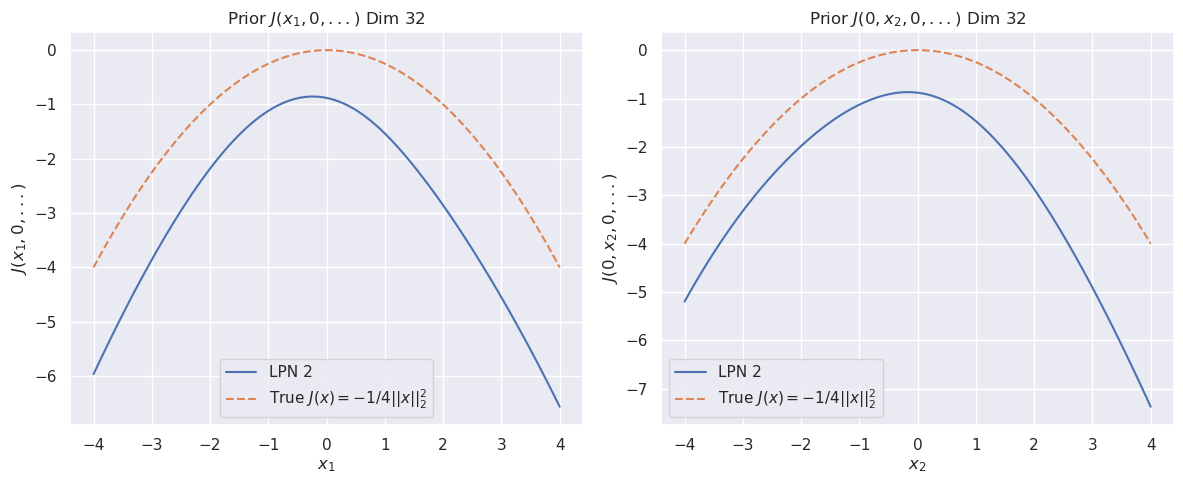

In [11]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    G_x = model_G.scalar(x_tensor)
    
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    
    # True Prior
    x1_0_J_true = prior_true_concave_quad(x1_0_points)
    if dim > 1:
        x2_0_J_true = prior_true_concave_quad(x2_0_points)
    else:
        x2_0_J_true = x1_0_J_true
        
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from LPN 2 ---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Prior $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$J(x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="True $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Prior $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$J(0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a_exp, spacing, dim_exp)